In [2]:
import yaml
import sys
import os
import re
import math

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import matplotlib.patches as patches
import seaborn as sns

PATH = "../pypsa-eur/"
RUN = "20240826-z1"

sys.path.append(os.path.join(PATH, "scripts/"))
from plot_summary import rename_techs

from snakemake.utils import update_config

plt.style.use(["bmh", "../pypsa-eur/matplotlibrc"])
xr.set_options(display_style="html")

In [3]:
CLUSTERS = 115
OUTPUT = f"./{RUN}/"

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)

SCENARIOS = PATH + "results/" + RUN + "/csvs/"

In [4]:
with open(f"../pypsa-eur/config/config.default.yaml") as base:
    config = yaml.safe_load(base)
    with open(f"../pypsa-eur/config/config.{RUN}.yaml") as file:
        update_config(config, yaml.safe_load(file))

In [5]:
def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    elif tech in ["H2", "H2 Store"]:
        return "hydrogen storage"
    elif tech in [
        "OCGT",
        "CHP",
        "OCGT methanol",
        "gas boiler",
        "H2 Fuel Cell",
        "H2 turbine",
    ]:
        return "gas-to-power/heat"
    elif "solar" in tech and not "external" in tech:
        return "solar"
    elif "battery" in tech and not "external" in tech:
        return "battery"
    elif tech in [
        "Fischer-Tropsch",
        "methanolisation",
        "Sabatier",
        "methanation",
        "Haber-Bosch",
    ]:
        return "hydrogen conversion"
    elif "offshore wind" in tech:
        return "offshore wind"
    elif (
        "CC" in tech
        or "sequestration" in tech
        or "sequester" in tech
        or "direct air capture" in tech
        or tech == "DAC"
    ):
        return "carbon capture and storage"
    elif "bio" in tech:
        return "biomass"
    elif tech == "import infrastructure pipeline-h2":
        return "import pipeline-h2"
    elif tech == "import infrastructure shipping-lh2":
        return "import shipping-lh2"
    elif tech == "import infrastructure shipping-lch4":
        return "import shipping-lch4"
    elif tech in ["oil primary", "oil", "gas"]:
        return "fossil"
    elif tech in ["ammonia cracker", "SMR", "H2 Electrolysis"]:
        return "hydrogen production"
    elif tech in [
        "DRI",
        "EAF",
        "electic arc furnace",
        "H2 pipeline",
        "gas pipeline",
        "hot water storage",
    ]:
        return "other"
    else:
        return tech

In [6]:
NICE_NAMES = {
    "external onwind": "onshore wind (abroad)",
    "external solar": "solar (abroad)",
    "external battery": "battery (abroad)",
    "import hvdc-to-elec": "HVDC import links",
    "import pipeline-h2": "hydrogen imports (pipeline)",
    "import shipping-lh2": "hydrogen imports (ship)",
    "import shipping-ftfuel": "Fischer-Tropsch imports",
    "import shipping-meoh": "methanol imports (ship)",
    "import shipping-lch4": "methane imports (ship)",
    "import shipping-lnh3": "ammonia imports (ship)",
    "import shipping-steel": "steel imports (ship)",
    "import shipping-hbi": "HBI imports (ship)",
}

In [7]:
preferred_order = pd.Index(
    [
        "transmission lines",
        "electricity distribution grid",
        "fossil oil and gas",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "nuclear",
        "solid biomass",
        "biogas",
        "biomass",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "solar PV",
        "solar thermal",
        "solar rooftop",
        "solar",
        "building retrofitting" "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "power-to-heat",
        "H2 Fuel Cell",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "gas pipeline",
        "H2 pipeline",
        "pipeline",
        "CO2 sequestration",
        "CCS",
        "carbon capture and storage",
        "power-to-gas",
        "power-to-H2",
        "H2 Electrolysis",
        "hydrogen production",
        "H2 liquefaction",
        "H2 storage",
        "hydrogen storage",
        "methanation",
        "power-to-liquid",
        "hydrogen conversion",
        "battery storage",
        "battery",
        "hot water storage",
        "fossil oil",
        "fossil",
        "oil",
        "oil primary",
        "methanol",
        "other",
        # Imports
        "external onwind",
        "external solar",
        "external battery",
        "import hvdc-to-elec",
        "import pipeline-h2",
        "import shipping-lh2",
        "import shipping-lnh3",
        "import shipping-lch4",
        "import shipping-meoh",
        "import shipping-ftfuel",
        "import shipping-hbi",
        "import shipping-steel",
    ]
)

In [8]:
def make_new_index(df):

    cols = df.columns.get_level_values("opt").str.split("-").str[-1].str.split("+", n=1)

    level1 = [
        "none" if not c0.startswith("imp") else ("any" if pd.isna(c1) else c1)
        for c0, c1 in zip(cols.str[0], cols.str[1])
    ]

    def parse_limit(c):
        try:
            return float(c)
        except:
            if c:
                return 0.0
            else:
                return np.inf
    
    def cost_year(s):
        match = re.search(r'CF\+costs\+year\+(\d{4})', s)
        return int(match.group(1)) if match else 2040

    level0 = cols.str[0].str[3:].map(parse_limit)

    opts = df.columns.get_level_values("opt")

    level2 = opts.map(lambda x: "no" if "norelocation" in x else "yes")

    level3 = opts.map(cost_year)

    df.columns = pd.MultiIndex.from_tuples(
        zip(level0, level1, level2, level3), names=["limit", "carrier", "relocation", "costs"]
    )

In [9]:
supply_energy = pd.read_csv(
    SCENARIOS + "supply_energy.csv", header=[0, 1, 2, 3], index_col=[0, 1, 2]
).fillna(0.0)

In [10]:
# temporary: remove final custom scenarios
supply_energy = supply_energy.iloc[:, :-10]
# supply_energy = supply_energy.loc[:, ~supply_energy.columns.get_level_values("opt").str.contains("0-9")]

In [11]:
make_new_index(supply_energy)

In [12]:
supply_energy = supply_energy.loc[
    ~supply_energy.index.get_level_values(2).str.contains("infrastructure")
    & ~supply_energy.index.get_level_values(2).str.contains("import hvdc-to-elec")
]

In [13]:
co2_carriers = [
    "co2",
    "co2 stored",
    "co2 sequestered",
    "process emissions",
    "export",
    "external battery",
    "external H2",
]
carrier = [i for i in supply_energy.index.levels[0] if i not in co2_carriers]

In [14]:
supply_energy = supply_energy.loc[carrier].groupby(level=2).sum().div(1e6)

In [15]:
# 2.1 kWh / kg of steel and HBI (or MWh/t)
supply_energy.loc[
    supply_energy.index.str.contains("steel") | supply_energy.index.str.contains("hbi")
] *= 2.1

In [16]:
supply_energy.index = [
    (
        i[:-1]
        if ((i not in ["co2", "NH3", "H2"]) and (i[-1:] in ["0", "1", "2", "3"]))
        else i
    )
    for i in supply_energy.index
]

In [17]:
supply_energy = supply_energy.groupby(supply_energy.index).sum()
supply_energy = (
    supply_energy.groupby(supply_energy.index.map(rename_techs_tyndp))
    .sum()
    .sort_index()
)

In [18]:
to_drop = supply_energy.index[supply_energy.abs().max(axis=1).fillna(0.0) < 1]
supply_energy.drop(to_drop, inplace=True)

In [19]:
imp_vol = (
    supply_energy.filter(regex="(import|external)", axis=0)
    .sum()
    .xs(np.inf, level="limit")
    .xs("yes", level="relocation")
    .xs(2040, level="costs")
    .round()
)
imp_vol = imp_vol[~imp_vol.index.duplicated(keep="first")]

In [20]:
supply_energy.columns = pd.MultiIndex.from_tuples(
    [(0.0, c, r, y) if c == "none" else (l, c) for l, c, r, y in supply_energy.columns],
    names=supply_energy.columns.names,
)

In [21]:
costs = pd.read_csv(SCENARIOS + "costs.csv", header=[0, 1, 2, 3], index_col=[0, 1, 2])

In [22]:
# temporary: remove faulty scenario definition
# costs = costs.loc[:,~costs.columns.get_level_values('opt').str.contains("NH3-FT")]
costs = costs.iloc[:, :-10]
# costs = costs.loc[:, ~costs.columns.get_level_values("opt").str.contains("0-9")]

In [23]:
make_new_index(costs)

In [24]:
# remove fixed costs of existing infrastructure that only show up in a subset of scenarios
costs.drop(
    ("links", "capital", "import infrastructure shipping-lch4"),
    inplace=True,
    errors="ignore",
)

In [25]:
tech_colors = config["plotting"]["tech_colors"]
tech_colors["pipeline"] = tech_colors["gas pipeline"]
tech_colors["gas"] = "#baac9e"
tech_colors["gas-to-power/heat"] = tech_colors["CHP"]
tech_colors["fossil"] = tech_colors["oil"]
tech_colors["hydrogen production"] = tech_colors["H2 Electrolysis"]
tech_colors["hydrogen conversion"] = tech_colors["power-to-liquid"]

In [26]:
carrier, key = "any", "+-0%"
#carrier, key = "AC+H21.5+CH41.5+NH31.5+FT1.5+MeOH1.5+HBI1.5+St1.5", "+50%"
# carrier, key = "AC+H21.3+CH41.3+NH31.3+FT1.3+MeOH1.3+HBI1.3+St1.3", "+30%"
# carrier, key = "AC+H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+HBI1.2+St1.2", "+20%"
# carrier, key = "AC+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+HBI1.1+St1.1", "+10%"
# carrier, key = "AC+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+HBI0.9+St0.9", "-10%"
# carrier, key = "AC+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+HBI0.8+St0.8", "-20%"
# carrier, key = "AC+H20.7+CH40.7+NH30.7+FT0.7+MeOH0.7+HBI0.7+St0.7", "-30%"
# carrier, key = "AC+H20.5+CH40.5+NH30.5+FT0.5+MeOH0.5+HBI0.5+St0.5", "-50%"

df = costs.groupby(level=2).sum().div(1e9)
df = df.groupby(df.index.map(rename_techs_tyndp)).sum()
to_drop = df.index[df.max(axis=1).fillna(0.0) < 1]
df.drop(to_drop, inplace=True)
order = preferred_order.intersection(df.index).append(
    df.index.difference(preferred_order)
)
df = df.loc[order]

In [27]:
df_norelocation = df.xs(2040, level="costs", axis=1).xs("no", level='relocation', axis=1)
df_2030 = df.xs(2030, level="costs", axis=1).xs("yes", level='relocation', axis=1)
df_2050 = df.xs(2050, level="costs", axis=1).xs("yes", level='relocation', axis=1)
df = df.xs(2040, level="costs", axis=1).xs("yes", level='relocation', axis=1)

In [28]:
def fix_columns(x):
    x.columns = pd.MultiIndex.from_tuples(
        [(imp_vol.get(c, 0.0), c) if math.isinf(l) else (l, c) for l, c in x.columns],
        names=["limit", "carrier"],
    )

fix_columns(df)
fix_columns(df_norelocation)
fix_columns(df_2030)
fix_columns(df_2050)

In [29]:
def get_subset(df, carrier):
    sel = df.columns.get_level_values("carrier").isin(["none", carrier])

    dfr = df.loc[:, sel]

    dfr.columns = dfr.columns.get_level_values("limit")

    return dfr

In [30]:
dfr = get_subset(df, carrier)
supplemental_carriers = {
    "-50%": "AC+H20.5+CH40.5+NH30.5+FT0.5+MeOH0.5+HBI0.5+St0.5",
    "-30%": "AC+H20.7+CH40.7+NH30.7+FT0.7+MeOH0.7+HBI0.7+St0.7",
    "-20%": "AC+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+HBI0.8+St0.8",
    "-10%": "AC+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+HBI0.9+St0.9",
    "+-0%": "any",
    "+10%": "AC+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+HBI1.1+St1.1",
    "+20%": "AC+H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+HBI1.2+St1.2",
    "+30%": "AC+H21.3+CH41.3+NH31.3+FT1.3+MeOH1.3+HBI1.3+St1.3",
    "+50%": "AC+H21.5+CH41.5+NH31.5+FT1.5+MeOH1.5+HBI1.5+St1.5",
}
supplemental_sensitivity = {
    k: get_subset(df, v).sum().sort_index() for k, v in supplemental_carriers.items()
}
supplemental_internal_tsc = {
    k: get_subset(df, v)
    .filter(regex="^(?!(.*import|.*external)).*$", axis=0)
    .sum()
    .sort_index()
    for k, v in supplemental_carriers.items()
}

In [31]:
r = pd.concat(supplemental_sensitivity, axis=1).round(2).sort_index()

In [32]:
((r.loc[0.0] - r) / (r.loc[0.0] - r.min())).mul(100).round(1)

-50%   -30%   -20%   -10%    +-0%    +10%    +20%     +30%      +50%
limit                                                                         
0.0        0.0    0.0    0.0    0.0     0.0     0.0     0.0      0.0       0.0
201.0      NaN    NaN    NaN    NaN     NaN     NaN     NaN      NaN     100.0
500.0     34.4   43.2   47.7   51.7    56.0    65.5    79.8    100.0     -69.7
682.0      NaN    NaN    NaN    NaN     NaN     NaN     NaN     96.7       NaN
1000.0    59.1   73.0   79.8   84.8    89.5    93.5   100.0     89.0    -681.8
1011.0     NaN    NaN    NaN    NaN     NaN     NaN   100.0      NaN       NaN
1357.0     NaN    NaN    NaN    NaN     NaN   100.0     NaN      NaN       NaN
1500.0    78.1   92.3   97.1   98.9    99.8    99.5    89.4     15.3   -1651.5
1609.0     NaN    NaN    NaN    NaN   100.0     NaN     NaN      NaN       NaN
1756.0     NaN    NaN    NaN  100.0     NaN     NaN     NaN      NaN       NaN
2000.0    89.2   99.2  100.0   99.3    97.6    91.1    63.6    -96.7   -3212.1
2010.0     NaN    NaN  100.0    NaN     NaN     NaN     NaN      NaN       NaN
2646.0     NaN  100.0    NaN    NaN     NaN     NaN     NaN      NaN       NaN
3000.0    99.8   99.3   93.7   86.3    73.3    47.3   -37.4   -516.3   -7897.0
3167.0   100.0    NaN    NaN    NaN     NaN     NaN     NaN      NaN       NaN
4000.0    97.5   90.4   76.4   51.5    15.1   -57.4  -257.0  -1305.7  -15812.1
5000.0    89.3   68.4   43.0    0.2   -78.2  -241.7  -648.2  -2667.0  -27251.5
6000.0    75.5   32.1  -12.2  -86.3  -215.8  -494.0 -1210.1  -4761.0  -47942.4
7000.0    56.3  -15.4  -86.5 -199.0  -396.8  -824.5 -1940.6  -7465.7  -75803.0
8000.0    34.4  -73.1 -174.5 -331.5  -609.9 -1230.8 -2828.3 -10739.0 -109009.1
9000.0     9.6 -136.7 -273.3 -484.4  -858.6 -1688.7 -3831.4 -14444.3 -146139.4
10000.0  -18.6 -205.3 -377.9 -644.2 -1121.5 -2181.8 -4922.3 -18619.7 -188933.3

In [58]:
cy_any = pd.concat({
    2030: df_2030.xs("any", level="carrier", axis=1).squeeze(),
    2040: df.xs("any", level="carrier", axis=1).iloc[:,0],
    2050: df_2050.xs("any", level="carrier", axis=1).squeeze(),
}, axis=1).T

cy_none = pd.concat({
    2030: df_2030.xs("none", level="carrier", axis=1).squeeze(),
    2040: df.xs("none", level="carrier", axis=1).iloc[:,0],
    2050: df_2050.xs("none", level="carrier", axis=1).squeeze(),
}, axis=1).T

In [106]:
diff_none.sum(axis=1)

2030    74.374506
2050   -53.391825
dtype: float64

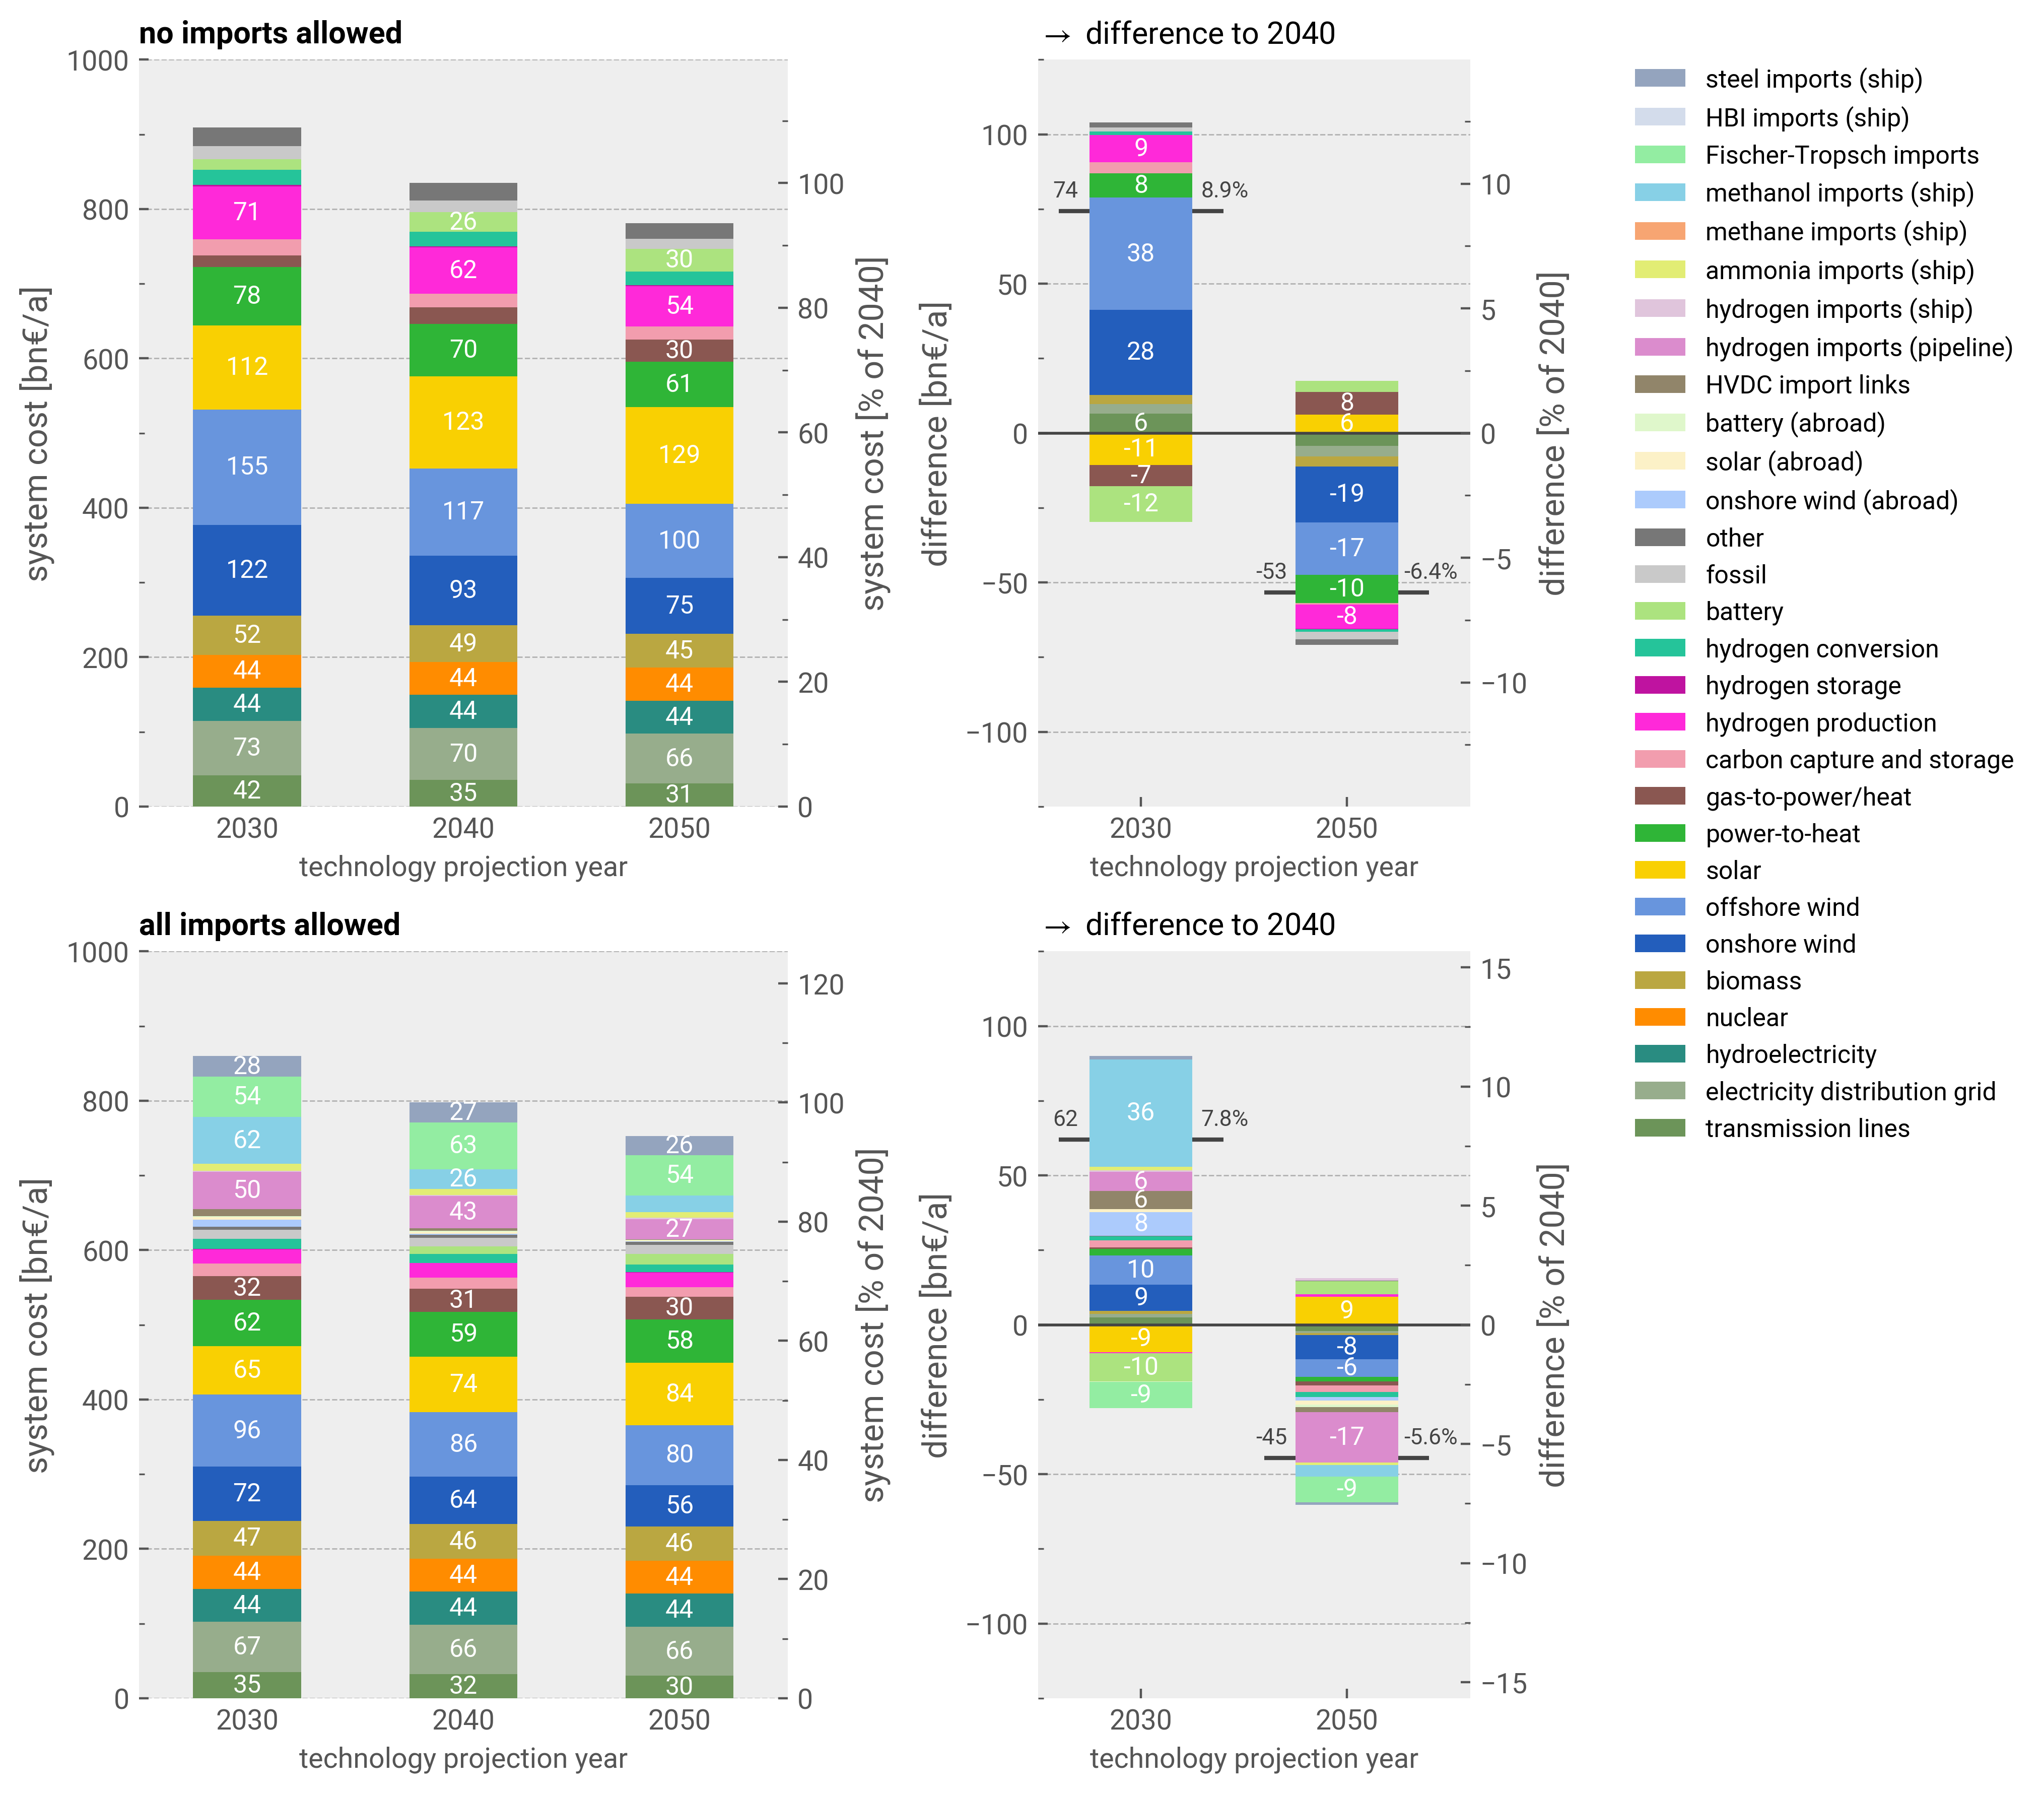

In [156]:
fig, (ax_top, ax_bottom) = plt.subplots(
    2,
    2,
    figsize=(8, 9),
    gridspec_kw={"width_ratios": [3, 2]},
)

kwargs = dict(
    stacked=True,
    color=tech_colors,
)

cy_none.plot.bar(ax=ax_top[0], legend=False, **kwargs)
cy_any.plot.bar(ax=ax_bottom[0], legend=False, **kwargs)

diff_any = (cy_any - cy_any.loc[2040]).drop(2040)
diff_none = (cy_none - cy_none.loc[2040]).drop(2040)

diff_none.plot.bar(ax=ax_top[1], legend=False, **kwargs)
diff_any.plot.bar(ax=ax_bottom[1], legend=False, **kwargs)

kwargs = dict(
    xmin=[-0.4, 0.6],
    xmax=[0.4, 1.4],
    color="#444",
    linestyle="-",
    linewidth=1.5,
    zorder=0,
)
ax_top[1].hlines(diff_none.sum(axis=1), **kwargs)
ax_bottom[1].hlines(diff_any.sum(axis=1), **kwargs)

kwargs = dict(textcoords="offset points", ha="center", fontsize=8, color="#444")
for i, (x, y) in enumerate(zip(range(len(diff_none)), diff_none.sum(axis=1))):
    ax_top[1].annotate(f"{y:.0f}", (x, y), xytext=(-27, 5), **kwargs)
    ax_top[1].annotate(f"{y / cy_none.loc[2040].sum() * 100:.1f}%", (x, y), xytext=(30, 5), **kwargs)

for i, (x, y) in enumerate(zip(range(len(diff_any)), diff_any.sum(axis=1))):
    ax_bottom[1].annotate(f"{y:.0f}", (x, y), xytext=(-27, 5), **kwargs)
    ax_bottom[1].annotate(f"{y / cy_any.loc[2040].sum() * 100:.1f}%", (x, y), xytext=(30, 5), **kwargs)

ax_top[0].set_title("no imports allowed", loc="left", fontsize=11, weight="bold")
ax_top[1].set_title(r"$\rightarrow$ difference to 2040", loc="left", fontsize=11)
ax_bottom[0].set_title("all imports allowed", loc="left", fontsize=11, weight="bold")
ax_bottom[1].set_title(r"$\rightarrow$ difference to 2040", loc="left", fontsize=11)

ax_top[0].set_ylabel("system cost [bn€/a]")
ax_bottom[0].set_ylabel("system cost [bn€/a]")

ax_top[1].set_ylabel("difference [bn€/a]")
ax_bottom[1].set_ylabel("difference [bn€/a]")

ax_top[0].grid(axis="x")
ax_top[0].set_ylim(0, 1000)
ax_top[0].tick_params(rotation=0, labelsize=10)
ax_top[0].set_xlabel("technology projection year", fontsize=10)

ax_bottom[0].grid(axis="x")
ax_bottom[0].set_ylim(0, 1000)
ax_bottom[0].tick_params(rotation=0, labelsize=10)
ax_bottom[0].set_xlabel("technology projection year", fontsize=10)

ax_bottom[1].grid(axis="x")
ax_bottom[1].set_ylim(-125, 125)
ax_bottom[1].tick_params(rotation=0, labelsize=10)
ax_bottom[1].set_xlabel("technology projection year", fontsize=10)

ax_top[1].grid(axis="x")
ax_top[1].set_ylim(-125, 125)
ax_top[1].tick_params(rotation=0, labelsize=10)
ax_top[1].set_xlabel("technology projection year", fontsize=10)

def abs_fmt(x):
    return f"{x:.0f}" if x > 25 else ""

def rel_fmt(x):
    return f"{x:.0f}" if abs(x) > 5 else ""

for ax in (ax_top[0], ax_bottom[0]):
    for container in ax.containers:
        ax.bar_label(container, label_type="center", color="white", fmt=abs_fmt, fontsize=9)

for ax in (ax_top[1], ax_bottom[1]):
    for container in ax.containers:
        ax.bar_label(container, label_type="center", color="white", fmt=rel_fmt, fontsize=9)

def abs2rel(x):
    return x / cy_none.loc[2040].sum() * 100

def rel2abs(x):
    return x * cy_none.loc[2040].sum() / 100

secax_top = ax_top[0].secondary_yaxis("right", functions=(abs2rel, rel2abs), zorder=10)
secax_top.set_ylabel("system cost [% of 2040]")

secax_tright = ax_top[1].secondary_yaxis("right", functions=(abs2rel, rel2abs), zorder=10)
secax_tright.set_ylabel("difference [% of 2040]")

def abs2rel(x):
    return x / cy_any.loc[2040].sum() * 100

def rel2abs(x):
    return x * cy_any.loc[2040].sum() / 100

secax_bottom = ax_bottom[0].secondary_yaxis("right", functions=(abs2rel, rel2abs), zorder=10)
secax_bottom.set_ylabel("system cost [% of 2040]")

secax_bright = ax_bottom[1].secondary_yaxis("right", functions=(abs2rel, rel2abs), zorder=10)
secax_bright.set_ylabel("difference [% of 2040]")

ax_top[0].set_yticks(range(0, 1001, 100), minor=True)
ax_bottom[0].set_yticks(range(0, 1001, 100), minor=True)

ax_top[1].set_yticks(range(-125, 126, 25), minor=True)
ax_bottom[1].set_yticks(range(-125, 126, 25), minor=True)

secax_top.set_yticks(range(0, 111, 10), minor=True)
secax_bottom.set_yticks(range(0, 111, 10), minor=True)

secax_tright.set_yticks(np.arange(-12.5, 12.6, 2.5), minor=True)
secax_bright.set_yticks(np.arange(-12.5, 12.6, 2.5), minor=True)


handles, labels = ax_bottom[0].get_legend_handles_labels()

labels = [NICE_NAMES.get(i, i) for i in labels]

handles.reverse()
labels.reverse()

fig.legend(
    handles, labels, ncol=1, frameon=False, fontsize=9, bbox_to_anchor=(1.27, 0.97)
)

ax_top[1].set_xlim(-0.5, 1.6)
ax_bottom[1].set_xlim(-0.5, 1.6)

ax_top[1].axhline(0, color="#444", linewidth=1, zorder=1)
ax_bottom[1].axhline(0, color="#444", linewidth=1, zorder=1)

for i in ["top", "right", "left", "bottom"]:
    ax_top[0].spines[i].set_visible(False)
    ax_top[1].spines[i].set_visible(False)
    ax_bottom[0].spines[i].set_visible(False)
    ax_bottom[1].spines[i].set_visible(False)
    secax_top.spines[i].set_visible(False)
    secax_bottom.spines[i].set_visible(False)
    secax_bright.spines[i].set_visible(False)
    secax_tright.spines[i].set_visible(False)

for ext in [".pdf", ".png"]:
    fig.savefig(
        OUTPUT + "technology-year-sensitivity" + ext, bbox_inches="tight"
    )

/tmp/ipykernel_354484/573071241.py:6: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



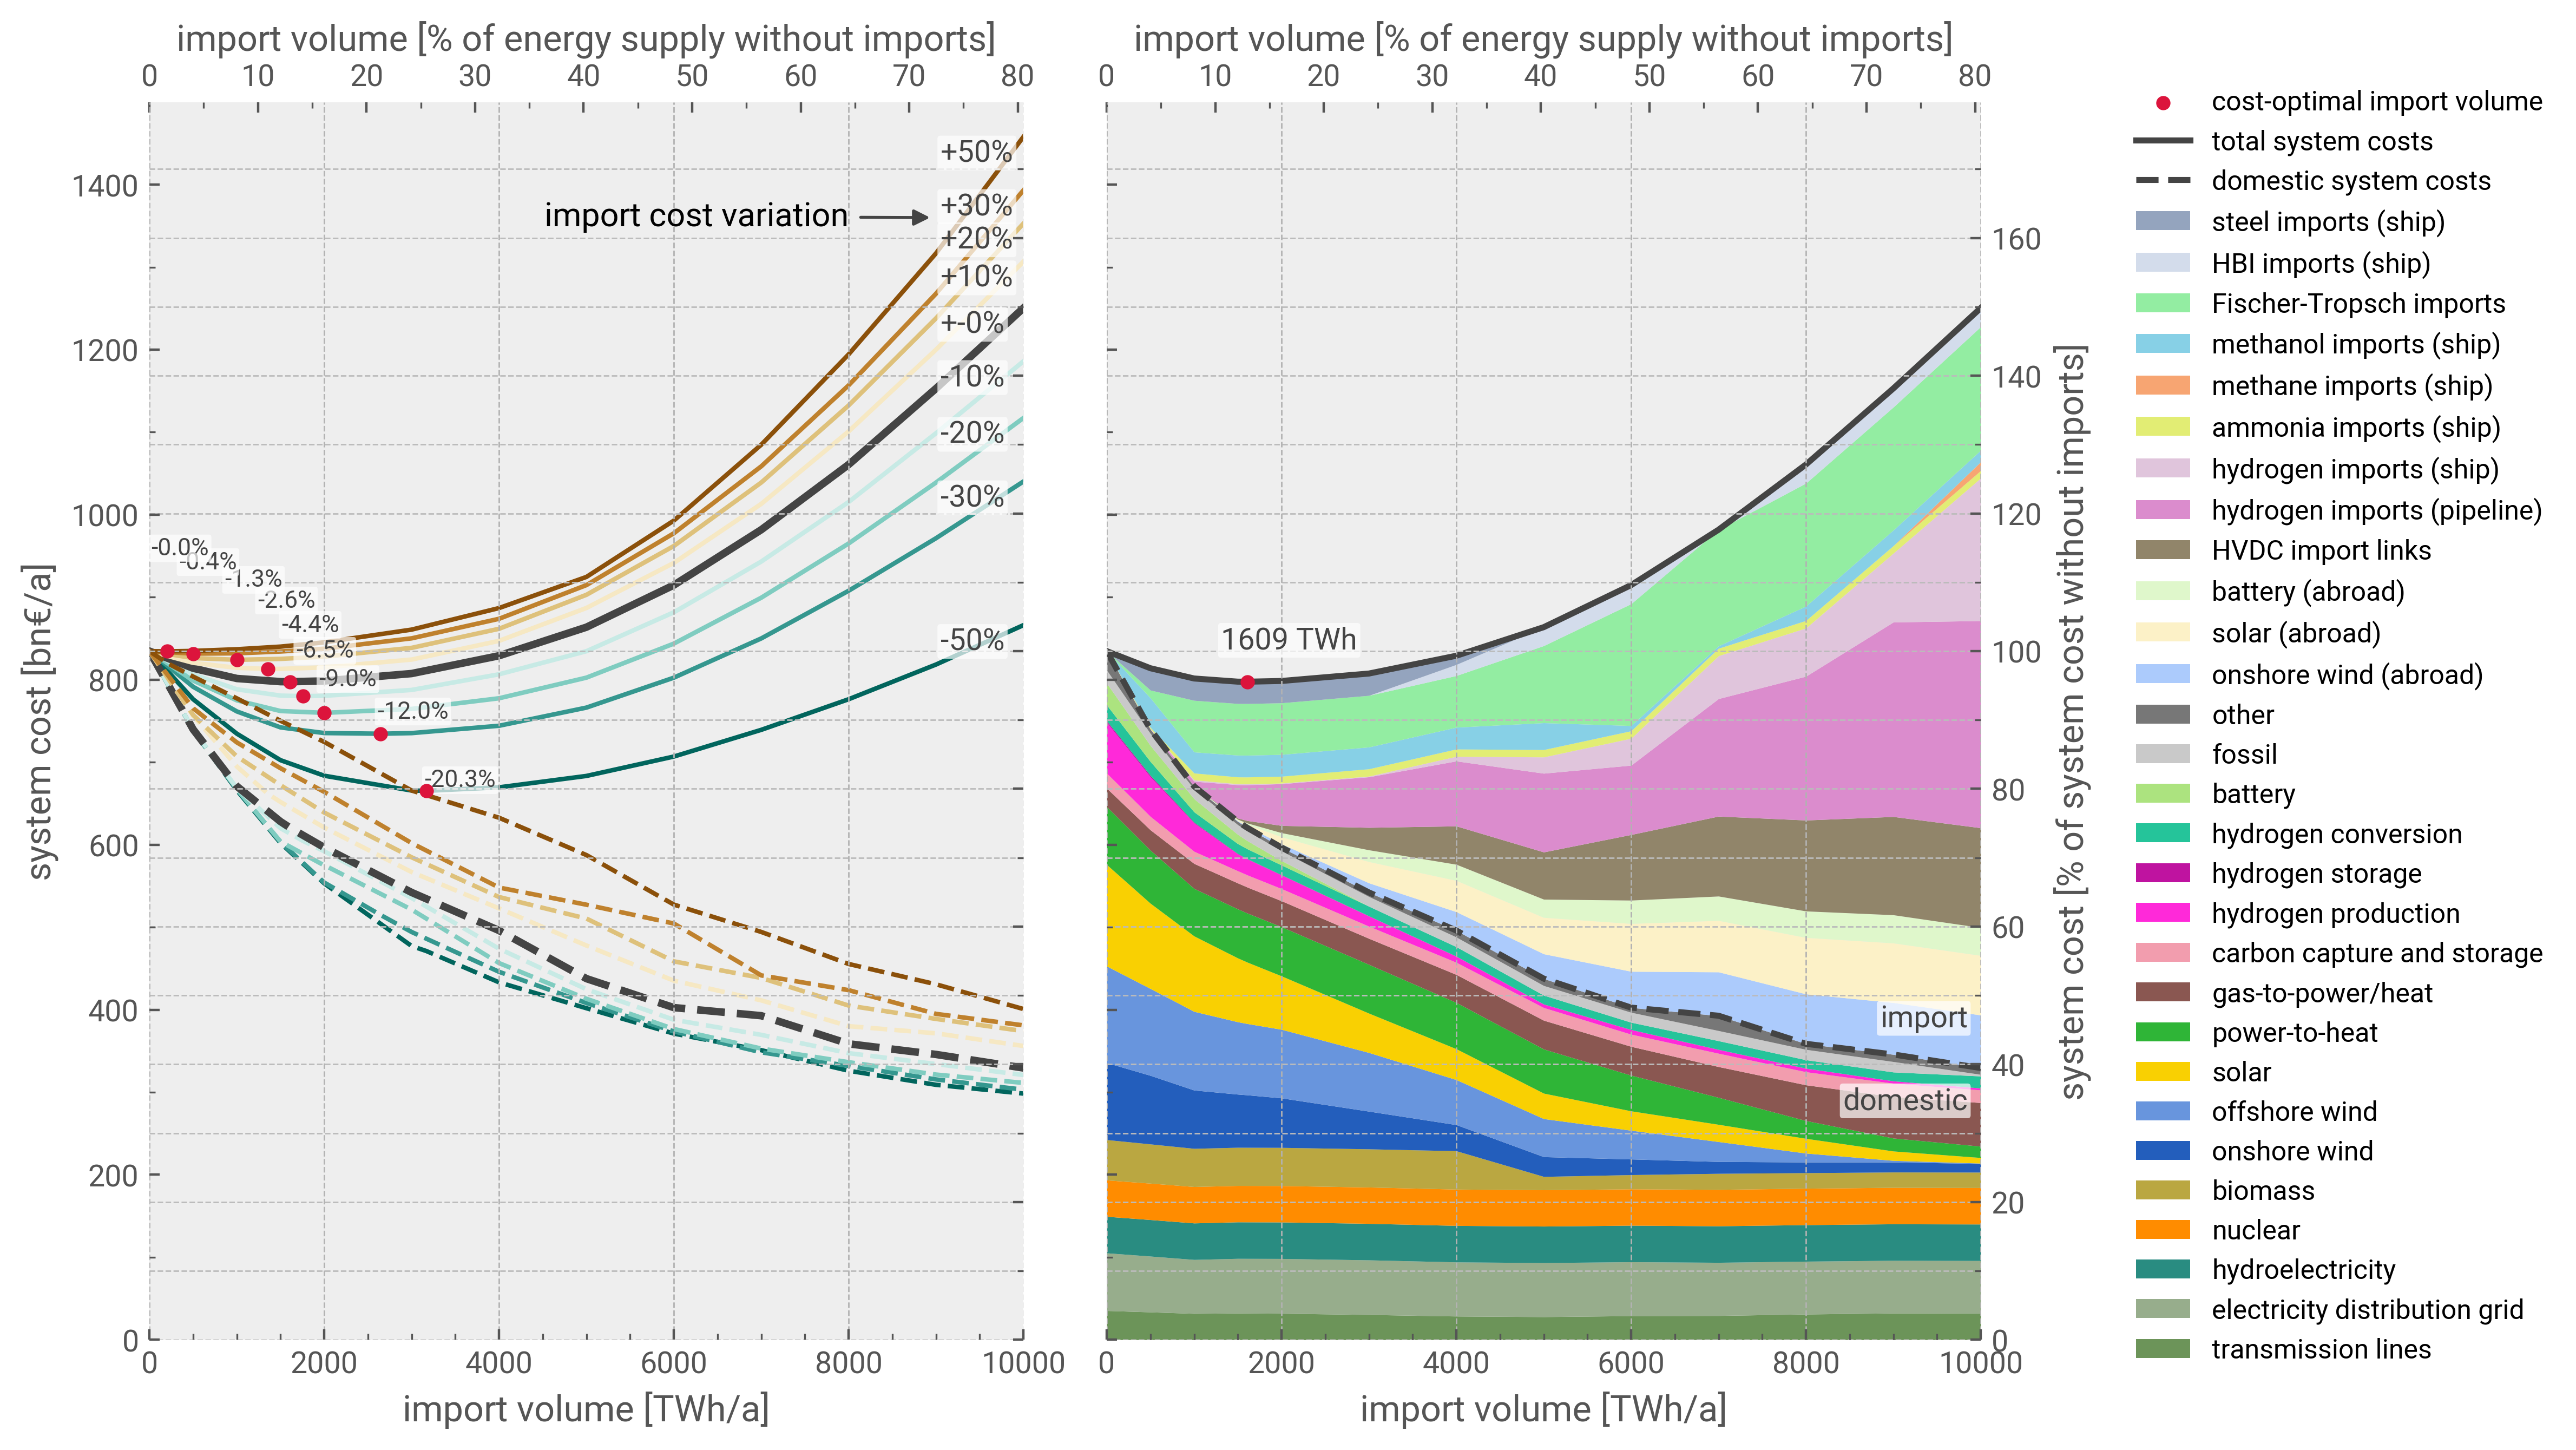

In [32]:
colors = sns.color_palette("BrBG", len(supplemental_internal_tsc.keys())).as_hex()[::-1]
var_colors = dict(zip(supplemental_internal_tsc.keys(), colors))

var_colors["+-0%"] = "#444"

internal_tsc = dfr.loc[~dfr.index.str.contains("(import|external)")].sum().sort_index()

fig, (ax_left, ax_right) = plt.subplots(
    1,
    2,
    figsize=(12, 6.8),
    sharey=True,
)

to_plot = dfr.T.sort_index()

no_import_costs = dfr[0.0].sum()

colors = [tech_colors.get(i, "grey") for i in df.index]

bbox = dict(boxstyle="round,pad=0.1", edgecolor="none", facecolor="white", alpha=0.7)

to_plot.plot.area(ax=ax_right, stacked=True, linewidth=0, color=colors)

supplemental_internal_tsc[key].plot(
    ax=ax_right,
    linestyle="--",
    linewidth=2,
    color="#444",
    label="domestic system costs",
)

supplemental_sensitivity[key].plot(
    ax=ax_right, linestyle="-", linewidth=2, color="#444", label="total system costs"
)

ax_right.scatter(11000, 2000, s=18, color="crimson", label="cost-optimal import volume")

ax_right.scatter(
    supplemental_sensitivity[key].idxmin(),
    supplemental_sensitivity[key].min(),
    s=18,
    color="crimson",
    zorder=99,
)

ax_right.annotate(
    f"{int(supplemental_sensitivity[key].idxmin())} TWh",
    (
        supplemental_sensitivity[key].idxmin() - 300,
        supplemental_sensitivity[key].min() + 40,
    ),
    color="#444",
    bbox=bbox,
    fontsize=10,
)

for i, (label, data) in enumerate(supplemental_sensitivity.items()):
    data.plot(
        ax=ax_left,
        linestyle="-",
        linewidth=2.5 if key == label else 1.5,
        color=var_colors[label],
        alpha=1,
        label="+/- X% import costs" if i == 0 else None,
    )

    minimum_rel = (data - no_import_costs).div(no_import_costs).mul(-100).round(1)
    minimum_abs = (no_import_costs - data).round(1)

    x = minimum_abs.idxmax()
    y = data.min()
    ax_left.scatter(
        x,
        y,
        color="crimson",
        s=18,
        zorder=99,
    )

    ax_left.annotate(
        f"-{minimum_rel[x]}%",
        (x - 20 - i * 20, y + 5 + i * 14),
        color="#444",
        bbox=bbox,
        fontsize=8,
    )

    ax_left.annotate(
        label,
        (9050, data.max() - 30),
        color="#444",
        bbox=bbox,
        fontsize=10,
    )


for i, (label, data) in enumerate(supplemental_internal_tsc.items()):
    data.plot(
        ax=ax_left,
        linestyle="--",
        linewidth=2.5 if key == label else 1.5,
        color=var_colors[label],
        alpha=1,
        label="+/- X% import costs" if i == 0 else None,
    )

ax_right.annotate(
    "domestic",
    (9850, internal_tsc.min() - 50),
    color="#444",
    bbox=bbox,
    fontsize=10,
    ha="right",
)

ax_right.annotate(
    "import",
    (9850, internal_tsc.min() + 50),
    color="#444",
    bbox=bbox,
    fontsize=10,
    ha="right",
)

ax_left.annotate(
    "import cost variation",
    (9000, 1360),
    xytext=(8000, 1350),
    fontsize=11,
    ha="right",
    arrowprops=dict(
        arrowstyle="-|>",
        color="#444",
        lw=1,
    ),
)

handles, labels = ax_right.get_legend_handles_labels()

labels = [NICE_NAMES.get(i, i) for i in labels]

handles.reverse()
labels.reverse()

ax_right.legend(
    handles, labels, ncol=1, frameon=False, fontsize=9, bbox_to_anchor=(1.15, 1.03)
)


def abs2rel(x):
    return x / no_import_costs * 100


def rel2abs(x):
    return x * no_import_costs / 100


secax2 = ax_right.secondary_yaxis("right", functions=(abs2rel, rel2abs), zorder=10)
secax2.set_ylabel("system cost [% of system cost without imports]")

secax2.set_yticks(
    [0, 20, 40, 60, 80, 100, 120, 140, 160, 180],
)
secax2.set_yticks([10, 30, 50, 70, 90, 110, 130, 150, 170], minor=True)

secax_left = ax_left.secondary_yaxis("right", functions=(abs2rel, rel2abs), zorder=10)
secax_left.set_yticks(
    [0, 20, 40, 60, 80, 100, 120, 140, 160, 180],
)
secax_left.set_yticks([10, 30, 50, 70, 90, 110, 130, 150, 170], minor=True)
secax_left.set_yticklabels([])

for ax in [ax_left, ax_right]:
    ax.set_xlim(0, 10000)
    ax.set_xlabel("import volume [TWh/a]")

    ax.set_ylim([0, 1500])
    ax.set_ylabel("system cost [bn€/a]")
    ax.grid(axis="y")

    ax.set_axisbelow(False)
    ax.tick_params(rotation=0)

    def abs2rel(x):
        return x / 12418.5 * 100

    def rel2abs(x):
        return x * 12418.5 / 100

    secax = ax.secondary_xaxis("top", functions=(abs2rel, rel2abs))
    secax.set_xlabel("import volume [% of energy supply without imports]")
    secax.set_xticks(range(5, 100, 10), minor=True)

    def abs2rel(x):
        return x / no_import_costs * 100

    def rel2abs(x):
        return x * no_import_costs / 100

    ax.set_yticks([100, 300, 500, 700, 900, 1100, 1300], minor=True)
    ax.set_xticks(range(500, 10000, 500), minor=True)

    for i in ["top", "right", "left", "bottom"]:
        secax.spines[i].set_visible(False)
        secax2.spines[i].set_visible(False)
        secax_left.spines[i].set_visible(False)
        ax.spines[i].set_visible(False)

    for y in range(0, 180, 10):
        ax.axhline(rel2abs(y), ls="--", color="#bbb", lw=0.5)

for ext in [".pdf", ".png"]:
    fig.savefig(
        OUTPUT + f"sensitivity-import-volume-{carrier}" + ext, bbox_inches="tight"
    )

In [36]:
suffix = ""

if suffix == "":
    translate = {
        "AC": "only\nelectricity",
        "H2": "only\nhydrogen",
        "CH4": "only\nmethane",
        "NH3": "only\nammonia",
        "FT": "only\nFischer-\nTropsch",
        "MeOH": "only\nmethanol",
        "MeOH+FT": "only\nmethanol\n& Fischer-\nTropsch",
        "HBI+St": "only\nHBI / steel",
        "H2+CH4+NH3+FT+MeOH": "all but\nelectricity\nand steel",
        "H2+CH4+NH3+FT+MeOH+HBI+St": "all but\nelectricity",
        "CH4+NH3+FT+MeOH+HBI+St": "only\nhydrogen\nderivatives\nand steel",
        "CH4+NH3+FT+MeOH": "only\nhydrogen\nderivatives",
        "any": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }
elif suffix == "-m20pc":
    translate = {
        "AC0.8": "only\nelectricity",
        "H20.8": "only\nhydrogen",
        "CH40.8": "only\nmethane",
        "NH30.8": "only\nammonia",
        "FT0.8": "only\nFischer-\nTropsch",
        "MeOH0.8": "only\nmethanol",
        "MeOH0.8+FT0.8": "only\nmethanol\n& Fischer-\nTropsch",
        "HBI0.8+St0.8": "only\nHBI / steel",
        "H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8": "all but\nelectricity\nand steel",
        "H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+HBI0.8+St0.8": "all but\nelectricity",
        "CH40.8+NH30.8+FT0.8+MeOH0.8+HBI0.8+St0.8": "only\nhydrogen\nderivatives\nand steel",
        "CH40.8+NH30.8+FT0.8+MeOH0.8": "only\nhydrogen\nderivatives",
        "AC+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+HBI0.8+St0.8": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }
elif suffix == "-m10pc":
    translate = {
        "AC0.9": "only\nelectricity",
        "H20.9": "only\nhydrogen",
        "CH40.9": "only\nmethane",
        "NH30.9": "only\nammonia",
        "FT0.9": "only\nFischer-\nTropsch",
        "MeOH0.9": "only\nmethanol",
        "MeOH0.9+FT0.9": "only\nmethanol\n& Fischer-\nTropsch",
        "HBI0.9+St0.9": "only\nHBI / steel",
        "H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9": "all but\nelectricity\nand steel",
        "H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+HBI0.9+St0.9": "all but\nelectricity",
        "CH40.9+NH30.9+FT0.9+MeOH0.9+HBI0.9+St0.9": "only\nhydrogen\nderivatives\nand steel",
        "CH40.9+NH30.9+FT0.9+MeOH0.9": "only\nhydrogen\nderivatives",
        "AC+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+HBI0.9+St0.9": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }
elif suffix == "-p10pc":
    translate = {
        "AC1.1": "only\nelectricity",
        "H21.1": "only\nhydrogen",
        "CH41.1": "only\nmethane",
        "NH31.1": "only\nammonia",
        "FT1.1": "only\nFischer-\nTropsch",
        "MeOH1.1": "only\nmethanol",
        "MeOH1.1+FT1.1": "only\nmethanol\n& Fischer-\nTropsch",
        "HBI1.1+St1.1": "only\nHBI / steel",
        "H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1": "all but\nelectricity\nand steel",
        "H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+HBI1.1+St1.1": "all but\nelectricity",
        "CH41.1+NH31.1+FT1.1+MeOH1.1+HBI1.1+St1.1": "only\nhydrogen\nderivatives\nand steel",
        "CH41.1+NH31.1+FT1.1+MeOH1.1": "only\nhydrogen\nderivatives",
        "AC+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+HBI1.1+St1.1": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }
elif suffix == "-p20pc":
    translate = {
        "AC1.2": "only\nelectricity",
        "H21.2": "only\nhydrogen",
        "CH41.2": "only\nmethane",
        "NH31.2": "only\nammonia",
        "FT1.2": "only\nFischer-\nTropsch",
        "MeOH1.2": "only\nmethanol",
        "MeOH1.2+FT1.2": "only\nmethanol\n& Fischer-\nTropsch",
        "HBI1.2+St1.2": "only\nHBI / steel",
        "H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2": "all but\nelectricity\nand steel",
        "H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+HBI1.2+St1.2": "all but\nelectricity",
        "CH41.2+NH31.2+FT1.2+MeOH1.2+HBI1.2+St1.2": "only\nhydrogen\nderivatives\nand steel",
        "CH41.2+NH31.2+FT1.2+MeOH1.2": "only\nhydrogen\nderivatives",
        "AC+H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+HBI1.2+St1.2": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }

In [37]:
to_plot = df.loc[
    :,
    ~df.columns.get_level_values("limit").isin(np.arange(500, 10001, 500))
    | df.columns.get_level_values("carrier").isin(
        ["MeOH1.2", "CH41.1+NH31.1+FT1.1+MeOH1.1"]
    ),
]

def prepare_to_plot(input_df):
    _df = input_df.copy()
    _df.columns = [
        "self-sufficient" if c[0] == 0.0 and c[1] == "none" else c[1]
        for c in _df.columns
    ]

    _df = _df.groupby(
        lambda x: x if "import" in x or "external" in x else "European system"
    ).sum()


    _df = _df.loc[:, translate.keys()].rename(columns=translate)

    _df = _df.loc[:, _df.sum().sort_values(ascending=False).index]

    _df = _df.groupby(
        lambda x: (
            "electricity imports (HVDC)"
            if x
            in [
                "external onwind",
                "external solar",
                "external battery",
                "import hvdc-to-elec",
            ]
            else x
        )
    ).sum()

    # make sure no imports is first
    first = "no\nimports"
    cols = [first] + [col for col in _df if col != first]
    return _df[cols]

to_plot = prepare_to_plot(to_plot)
if suffix == "":
    to_plot_norelocation = prepare_to_plot(df_norelocation)
    to_plot_2030 = prepare_to_plot(df_2030)
    to_plot_2050 = prepare_to_plot(df_2050)

abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

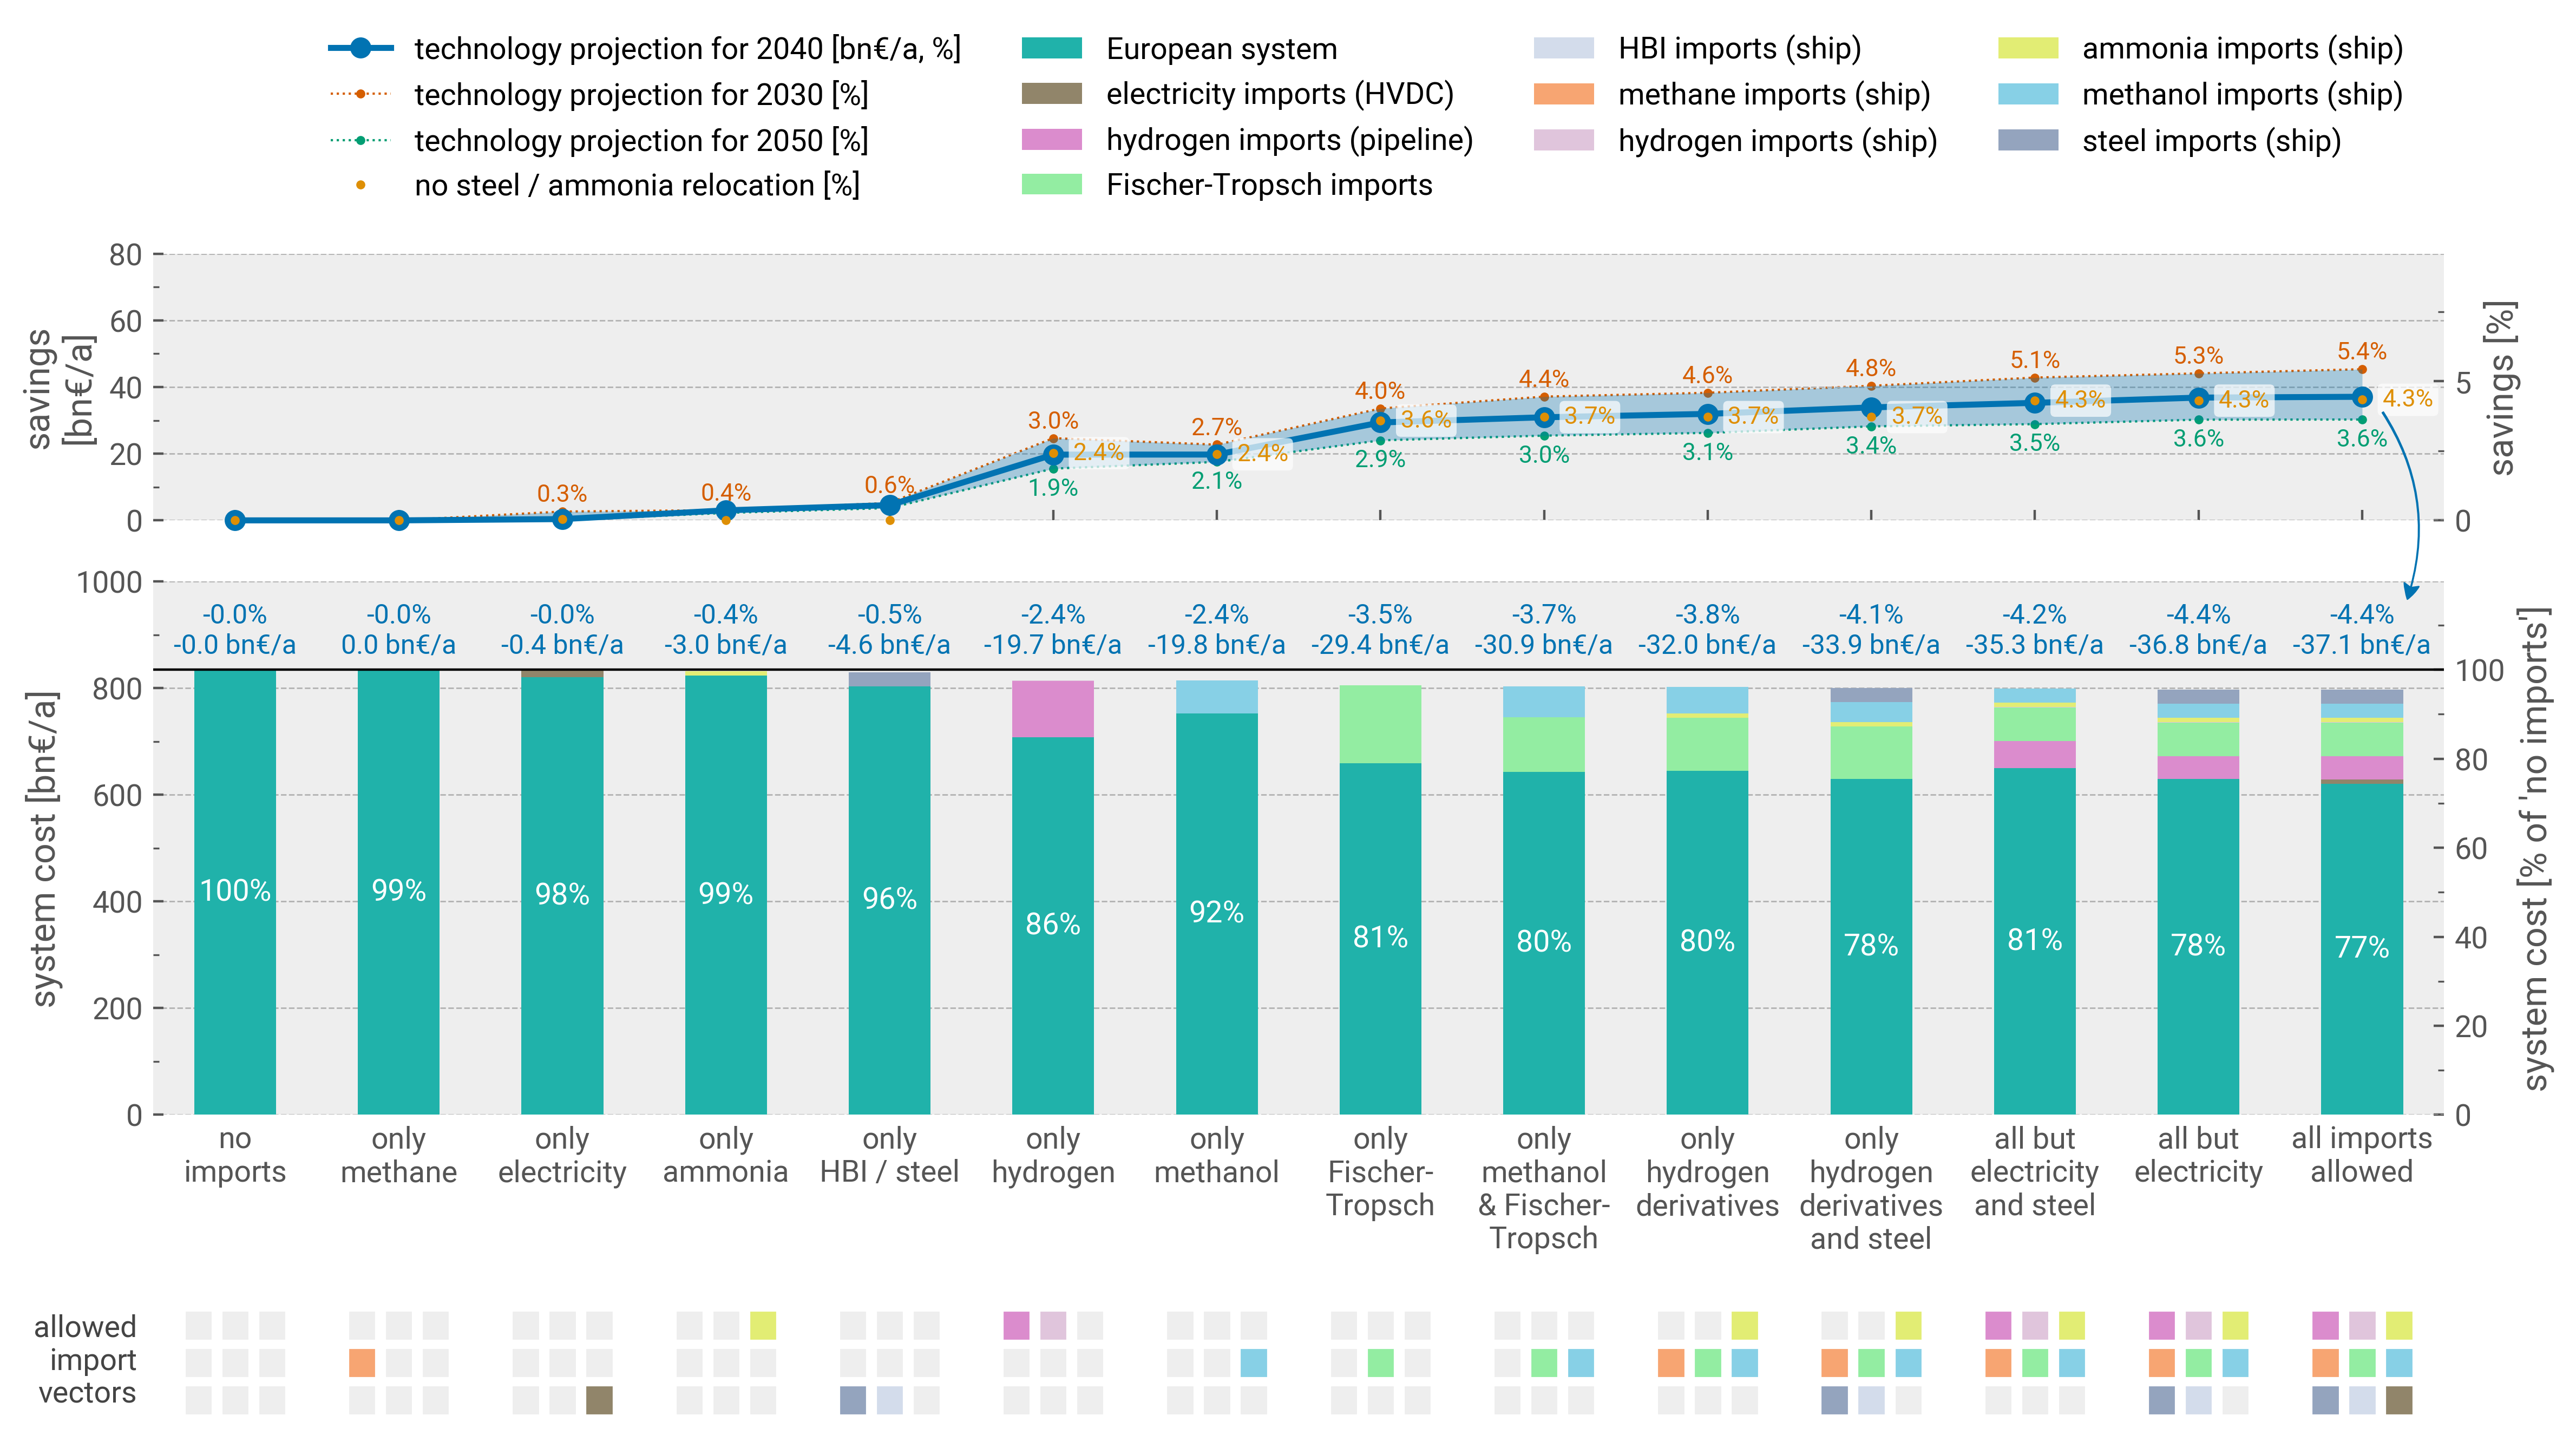

In [38]:
base_colors = sns.color_palette("colorblind")


fig, (ax2, ax) = plt.subplots(
    2,
    1,
    figsize=(12, 5.7),
    gridspec_kw={"height_ratios": [1.5, 3]},
    sharex=True,
)

tech_colors["European system"] = "lightseagreen"
tech_colors["Import"] = "coral"

reference_cost = to_plot["no\nimports"].sum()

to_plot.T.plot.bar(ax=ax, stacked=True, color=tech_colors, legend=False)

ax.set_ylim([0, 1000])
ax.set_ylabel("system cost [bn€/a]")
ax.grid(axis="x")

ax.axhline(to_plot.sum().max(), linestyle="-", color="k", linewidth=0.8)

share = to_plot / to_plot.sum() * 100
reduction = ((-to_plot.sum() + to_plot.sum().max()) / to_plot.sum().max() * 100).round(
    1
)
abs_reduction = (to_plot.sum() - to_plot.sum().max()).round(1)

for i, scen in enumerate(to_plot.columns):
    ax.text(
        i,
        865,
        f"-{reduction[scen]}%\n{abs_reduction[scen]} bn€/a",
        ha="center",
        fontsize=9,
        color=base_colors[0],
    )

ax.bar_label(
    ax.containers[0],
    labels=share.loc["European system"].astype(int).astype(str) + "%",
    label_type="center",
    color="white",
    fmt="%.0f",
)

ax.tick_params(rotation=0, labelsize=10)

def abs2rel(x):
    return x / reference_cost * 100


def rel2abs(x):
    return x * reference_cost / 100


secax = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax.set_ylabel("system cost [% of 'no imports']")

secax2 = ax2.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("savings [%]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

savings = to_plot.sum().max() - to_plot.sum()
label = "default technology projection" if suffix != "" else "technology projection for 2040"
savings.plot(ax=ax2, marker="o", color=base_colors[0], clip_on=False, label=label + " [bn€/a, %]")

if suffix == "":

    # TODO dummy data
    savings_2030 = (reference_cost - to_plot_2030.sum() / to_plot_2030["no\nimports"].sum() * reference_cost).loc[savings.index]
    savings_2050 = (reference_cost - to_plot_2050.sum() / to_plot_2050["no\nimports"].sum() * reference_cost).loc[savings.index]
    ax2.fill_between(savings_2030.index, savings_2030, savings_2050, color=base_colors[0], alpha=0.3, linewidth=0)
    # ax2.fill_between(savings_2030.index, savings_2030, savings_2050, color=base_colors[0], alpha=0.3, linewidth=0, label="cost projection range [%]")
    savings_2030.plot(ax=ax2, color=base_colors[3], marker="o", markersize=2, clip_on=False, linewidth=0.75, linestyle=":", label="technology projection for 2030 [%]", zorder=-1)
    savings_2050.plot(ax=ax2, color=base_colors[2], marker="o", markersize=2, clip_on=False, linewidth=0.75, linestyle=":", label="technology projection for 2050 [%]", zorder=-1)


    savings_no_relocation = (to_plot_norelocation.sum().max() / to_plot_norelocation.sum() * to_plot["no\nimports"].sum() - to_plot["no\nimports"].sum()).loc[savings.index]
    savings_no_relocation.plot(ax=ax2, marker="o", markersize=2, color=base_colors[1], clip_on=False, linewidth=0, label="no steel / ammonia relocation [%]")
    reference_cost = to_plot["no\nimports"].sum()
    for i, scen in enumerate(savings_no_relocation):
        if scen < 5:
            continue
        ax2.text(
            i + 0.28,
            scen - 2,
            f"{scen/reference_cost*100:.1f}%",
            ha="center",
            fontsize=8,
            color=base_colors[1],
            bbox=dict(
                facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.2"
            ),
        )


    kwargs = dict(
        ha="center",
        fontsize=8,
    )

    for i, scen in enumerate(savings_2030):
        if scen < 1:
            continue
        ax2.text(
            i,
            scen + 3,
            f"{scen/reference_cost*100:.1f}%",
            color=base_colors[3],
            **kwargs
        )

    for i, scen in enumerate(savings_2050):
        if scen < 5:
            continue
        ax2.text(
            i,
            scen - 8,
            f"{scen/reference_cost*100:.1f}%",
            color=base_colors[2],
            **kwargs
        )

handles1, labels1 = ax.get_legend_handles_labels()
labels1 = [NICE_NAMES.get(i, i) for i in labels1]
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles2 + handles1
labels = labels2 + labels1
fig.legend(handles, labels, ncol=4, frameon=False, bbox_to_anchor=(0.94, 1.165))


ax2.set_ylabel("savings\n[bn€/a]")
ax.set_yticks(range(100, 1000, 200), minor=True)
secax.set_yticks(range(10, 120, 20), minor=True)
ax2.grid(axis="x")

ax2.set_ylim(0, 80)
ax2.set_yticks(range(0, 81, 20))
ax2.set_yticks(range(10, 80, 10), minor=True)
secax2.set_yticks(range(0, 16, 5))
secax2.set_yticks([2.5, 7.5, 12.5], minor=True)


colors = {
    "pipeline-h2": "#db8ccd",
    "shipping-lh2": "#e0c5dc",
    "shipping-lnh3": "#e2ed74",
    "shipping-lch4": "#f7a572",
    "shipping-ftfuel": "#93eda2",
    "shipping-meoh": "#87d0e6",
    "shipping-steel": "#94a4be",
    "shipping-hbi": "#d3dceb",
    "hvdc-to-elec": "#91856a",
}

to_color_in = {
    "only\nelectricity": ["hvdc-to-elec"],
    "only\nhydrogen": ["pipeline-h2", "shipping-lh2"],
    "only\nmethane": ["shipping-lch4"],
    "only\nammonia": ["shipping-lnh3"],
    "only\nFischer-\nTropsch": ["shipping-ftfuel"],
    "only\nmethanol": ["shipping-meoh"],
    "only\nmethanol\n& Fischer-\nTropsch": ["shipping-meoh", "shipping-ftfuel"],
    "only\nHBI / steel": ["shipping-steel", "shipping-hbi"],
    "all but\nelectricity\nand steel": [
        "pipeline-h2",
        "shipping-lh2",
        "shipping-lch4",
        "shipping-lnh3",
        "shipping-ftfuel",
        "shipping-meoh",
    ],
    "all but\nelectricity": [
        "pipeline-h2",
        "shipping-lh2",
        "shipping-lch4",
        "shipping-lnh3",
        "shipping-ftfuel",
        "shipping-meoh",
        "shipping-hbi",
        "shipping-steel",
    ],
    "only\nhydrogen\nderivatives\nand steel": [
        "shipping-lch4",
        "shipping-lnh3",
        "shipping-ftfuel",
        "shipping-meoh",
        "shipping-hbi",
        "shipping-steel",
    ],
    "only\nhydrogen\nderivatives": [
        "shipping-lch4",
        "shipping-lnh3",
        "shipping-ftfuel",
        "shipping-meoh",
    ],
    "all imports\nallowed": [
        "pipeline-h2",
        "shipping-lh2",
        "shipping-lch4",
        "shipping-lnh3",
        "shipping-ftfuel",
        "shipping-meoh",
        "shipping-steel",
        "shipping-hbi",
        "hvdc-to-elec",
    ],
    "no\nimports": [],
}

for i, bar_id in enumerate(to_plot.columns):

    x_start = i - 0.3  # Starting x position
    y_position = -350  # Y position (below the x-axis)
    x_size = 0.15  # Size of the squares/circles
    y_size = 50

    for j, (key, color) in enumerate(colors.items()):
        if j % 3 == 0:
            x_start = i - 0.3
            y_position -= 70
        color = "#eee" if key not in to_color_in[bar_id] else color
        ax.add_patch(
            patches.Rectangle(
                (x_start, y_position), x_size, y_size, color=color, clip_on=False
            )
        )
        x_start += x_size * 1.5  # Move to the next position

if suffix == "":
    fig.patches.extend([
        patches.FancyArrowPatch(
            (0.92, 0.84),  # Start point (x1, y1)
            (0.93, 0.68),  # End point (x2, y2)
            transform=fig.transFigure,  # Use figure coordinates
            connectionstyle="arc3,rad=-0.25",  # Straight arrow. Use non-zero rad for curved
            arrowstyle="fancy,head_length=5,head_width=5",
            color=base_colors[0]
        )
    ])

ax.text(
    -0.6,
    -540,
    "allowed\nimport\nvectors",
    color="#444",
    ha="right",
)

for ext in [".pdf", ".png"]:
    fig.savefig(OUTPUT + f"sensitivity-bars{suffix}" + ext, bbox_inches="tight")

In [39]:
suffix = "-all"
to_plot = df.loc[:, ~df.columns.get_level_values(0).isin(np.arange(500, 10001, 500))]

def prepare_to_plot(input_df):
    _df = input_df.copy()
    _df.columns = [
        "self-sufficient" if c[0] == 0.0 and c[1] == "none" else c[1]
        for c in _df.columns
    ]

    _df = _df.groupby(
        lambda x: x if "import" in x or "external" in x else "European system"
    ).sum()

    translate = {
        "self-sufficient": "no\nimports",
        "AC+H21.3+CH41.3+NH31.3+FT1.3+MeOH1.3+HBI1.3+St1.3": "+30%",
        "AC+H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+HBI1.2+St1.2": "+20%",
        "AC+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+HBI1.1+St1.1": "+10%",
        "any": "+/- 0%",
        "AC+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+HBI0.9+St0.9": "-10%",
        "AC+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+HBI0.8+St0.8": "-20%",
        "AC+H20.7+CH40.7+NH30.7+FT0.7+MeOH0.7+HBI0.7+St0.7": "-30%",
        "AC+H20.6+CH40.6+NH30.6+FT0.6+MeOH0.6+HBI0.6+St0.6": "-40%",
        "AC+H20.5+CH40.5+NH30.5+FT0.5+MeOH0.5+HBI0.5+St0.5": "-50%",
    }

    _df = _df.loc[:, translate.keys()].rename(columns=translate)

    _df = _df.loc[:, _df.sum().sort_values(ascending=False).index]

    _df = _df.groupby(
        lambda x: (
            "electricity imports (HVDC)"
            if x
            in [
                "external onwind",
                "external solar",
                "external battery",
                "import hvdc-to-elec",
            ]
            else x
        )
    ).sum()

    # make sure no imports is first
    first = "no\nimports"
    cols = [first] + [col for col in _df if col != first]
    return _df[cols]

to_plot = prepare_to_plot(to_plot)
to_plot_2030 = prepare_to_plot(df_2030)
to_plot_2050 = prepare_to_plot(df_2050)

abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

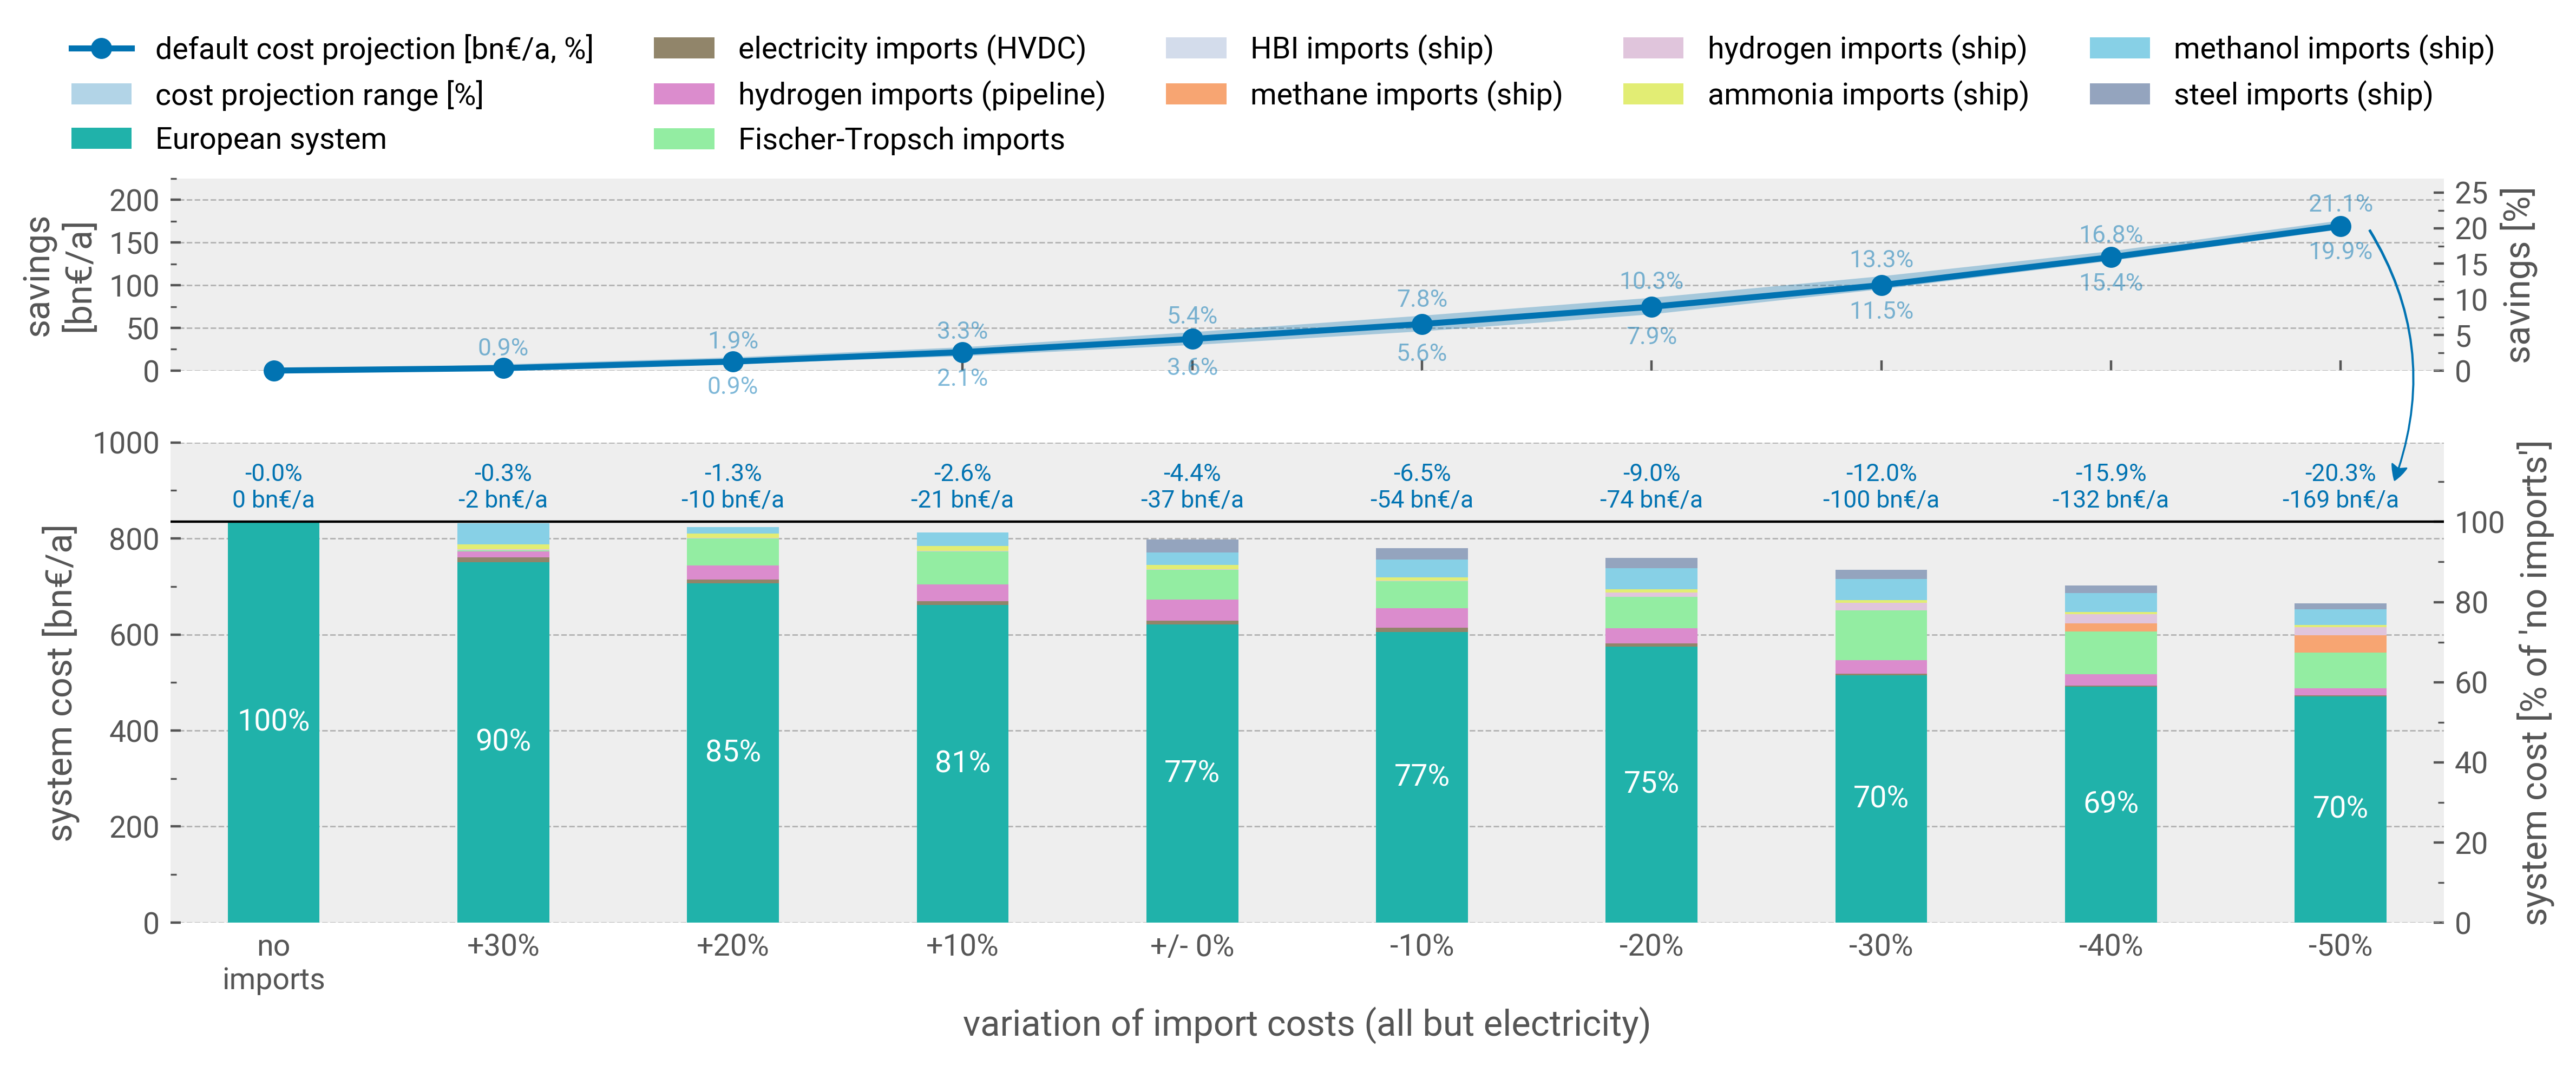

In [42]:
fig, (ax2, ax) = plt.subplots(
    2,
    1,
    figsize=(12, 4.3),
    gridspec_kw={"height_ratios": [1.2, 3]},
    sharex=True,
)

tech_colors["European system"] = "lightseagreen"
tech_colors["Import"] = "coral"

reference_cost = to_plot["no\nimports"].sum()

to_plot.T.plot.bar(ax=ax, stacked=True, width=0.4, color=tech_colors, legend=False)

ax.set_ylim([0, 1000])
ax.set_ylabel("system cost [bn€/a]")
ax.grid(axis="x")

ax.axhline(to_plot.sum().max(), linestyle="-", color="k", linewidth=0.8)

share = to_plot / to_plot.sum() * 100
reduction = ((-to_plot.sum() + to_plot.sum().max()) / to_plot.sum().max() * 100).round(
    1
)
abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

for i, scen in enumerate(to_plot.columns):
    ax.text(
        i,
        865,
        f"-{reduction[scen]}%\n{abs_reduction[scen]} bn€/a",
        ha="center",
        fontsize=8,
        color=base_colors[0],
        # bbox=dict(
        #     facecolor="white", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3"
        # ),
    )

ax.bar_label(
    ax.containers[0],
    labels=share.loc["European system"].astype(int).astype(str) + "%",
    label_type="center",
    color="white",
    fmt="%.0f",
)

ax.tick_params(rotation=0, labelsize=10)


def abs2rel(x):
    return x / reference_cost * 100


def rel2abs(x):
    return x * reference_cost / 100


secax = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax.set_ylabel("system cost [% of 'no imports']")

secax2 = ax2.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("savings [%]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

savings = to_plot.sum().max() - to_plot.sum()

savings.plot(ax=ax2, marker="o", color=base_colors[0], clip_on=False, label="default cost projection [bn€/a, %]")

savings_2030 = (reference_cost - to_plot_2030.sum() / to_plot_2030["no\nimports"].sum() * reference_cost).loc[savings.index]
savings_2050 = (reference_cost - to_plot_2050.sum() / to_plot_2050["no\nimports"].sum() * reference_cost).loc[savings.index]
ax2.fill_between(savings.index, savings_2050, savings_2030, color=base_colors[0], alpha=0.3, linewidth=0, label="cost projection range [%]")
# savings_2030.plot(ax=ax2, color=base_colors[0], clip_on=False, linewidth=0.5, linestyle=":")
# savings_2050.plot(ax=ax2, color=base_colors[0], clip_on=False, linewidth=0.5, linestyle=":")

kwargs = dict(
    ha="center",
    fontsize=8,
    color=base_colors[0],
    alpha=0.5,
)

for i, scen in enumerate(savings_2030):
    if scen < 1:
        continue
    ax2.text(
        i,
        scen + 10,
        f"{scen/reference_cost*100:.1f}%",
        **kwargs
    )

for i, scen in enumerate(savings_2050):
    if scen < 5:
        continue
    ax2.text(
        i,
        scen - 35,
        f"{scen/reference_cost*100:.1f}%",
        **kwargs
    )

handles1, labels1 = ax.get_legend_handles_labels()
labels1 = [NICE_NAMES.get(i, i) for i in labels1]
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles2 + handles1
labels = labels2 + labels1
fig.legend(handles, labels, ncol=5, frameon=False, bbox_to_anchor=(0.975, 1.15))

fig.patches.extend([
    patches.FancyArrowPatch(
        (0.915, 0.915),  # Start point (x1, y1)
        (0.925, 0.635),  # End point (x2, y2)
        transform=fig.transFigure,  # Use figure coordinates
        connectionstyle="arc3,rad=-0.25",  # Straight arrow. Use non-zero rad for curved
        arrowstyle="fancy,head_length=5,head_width=5",
        color=base_colors[0]
    )
])

ax2.set_ylabel("savings\n[bn€/a]")
ax2.set_ylim(0, 225)
ax2.set_yticks(range(0, 226, 50))
ax2.grid(axis="x")
secax2.set_yticks([0, 5, 10, 15, 20, 25, 30])
secax2.set_yticks([2.5, 7.5, 12.5, 17.5, 22.5, 27.5], minor=True)
secax.set_yticks(range(10, 120, 20), minor=True)
ax.set_yticks(range(100, 1000, 200), minor=True)
ax2.set_yticks(range(0, 226, 25), minor=True)

ax.set_xlabel("variation of import costs (all but electricity)")

for ext in [".pdf", ".png"]:
    fig.savefig(OUTPUT + f"sensitivity-bars{suffix}" + ext, bbox_inches="tight")

In [43]:
suffix = "-all-C"
to_plot = df.loc[:, ~df.columns.get_level_values(0).isin(np.arange(500, 10001, 500))]

def prepare_to_plot(input_df):
    _df = input_df.copy()
    _df.columns = [
        "self-sufficient" if c[0] == 0.0 and c[1] == "none" else c[1]
        for c in _df.columns
    ]

    _df = _df.groupby(
        lambda x: x if "import" in x or "external" in x else "European system"
    ).sum()

    translate = {
        "self-sufficient": "no\nimports",
        "AC+H2+CH41.3+NH3+FT1.3+MeOH1.3+HBI+St": "+30%",
        "AC+H2+CH41.2+NH3+FT1.2+MeOH1.2+HBI+St": "+20%",
        "AC+H2+CH41.2+NH3+FT1.2+MeOH1.2+HBI+St": "+20%",
        "AC+H2+CH41.1+NH3+FT1.1+MeOH1.1+HBI+St": "+10%",
        "any": "+/- 0%",
        "AC+H2+CH40.9+NH3+FT0.9+MeOH0.9+HBI+St": "-10%",
        "AC+H2+CH40.8+NH3+FT0.8+MeOH0.8+HBI+St": "-20%",
        "AC+H2+CH40.7+NH3+FT0.7+MeOH0.7+HBI+St": "-30%",
        "AC+H2+CH40.6+NH3+FT0.6+MeOH0.6+HBI+St": "-40%",
        "AC+H2+CH40.5+NH3+FT0.5+MeOH0.5+HBI+St": "-50%",
    }

    _df = _df.loc[:, translate.keys()].rename(columns=translate)

    _df = _df.loc[:, _df.sum().sort_values(ascending=False).index]

    _df = _df.groupby(
        lambda x: (
            "electricity imports (HVDC)"
            if x
            in [
                "external onwind",
                "external solar",
                "external battery",
                "import hvdc-to-elec",
            ]
            else x
        )
    ).sum()

    # make sure no imports is first
    first = "no\nimports"
    cols = [first] + [col for col in _df if col != first]
    return _df[cols]

to_plot = prepare_to_plot(to_plot)
to_plot_2030 = prepare_to_plot(df_2030)
to_plot_2050 = prepare_to_plot(df_2050)

abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)



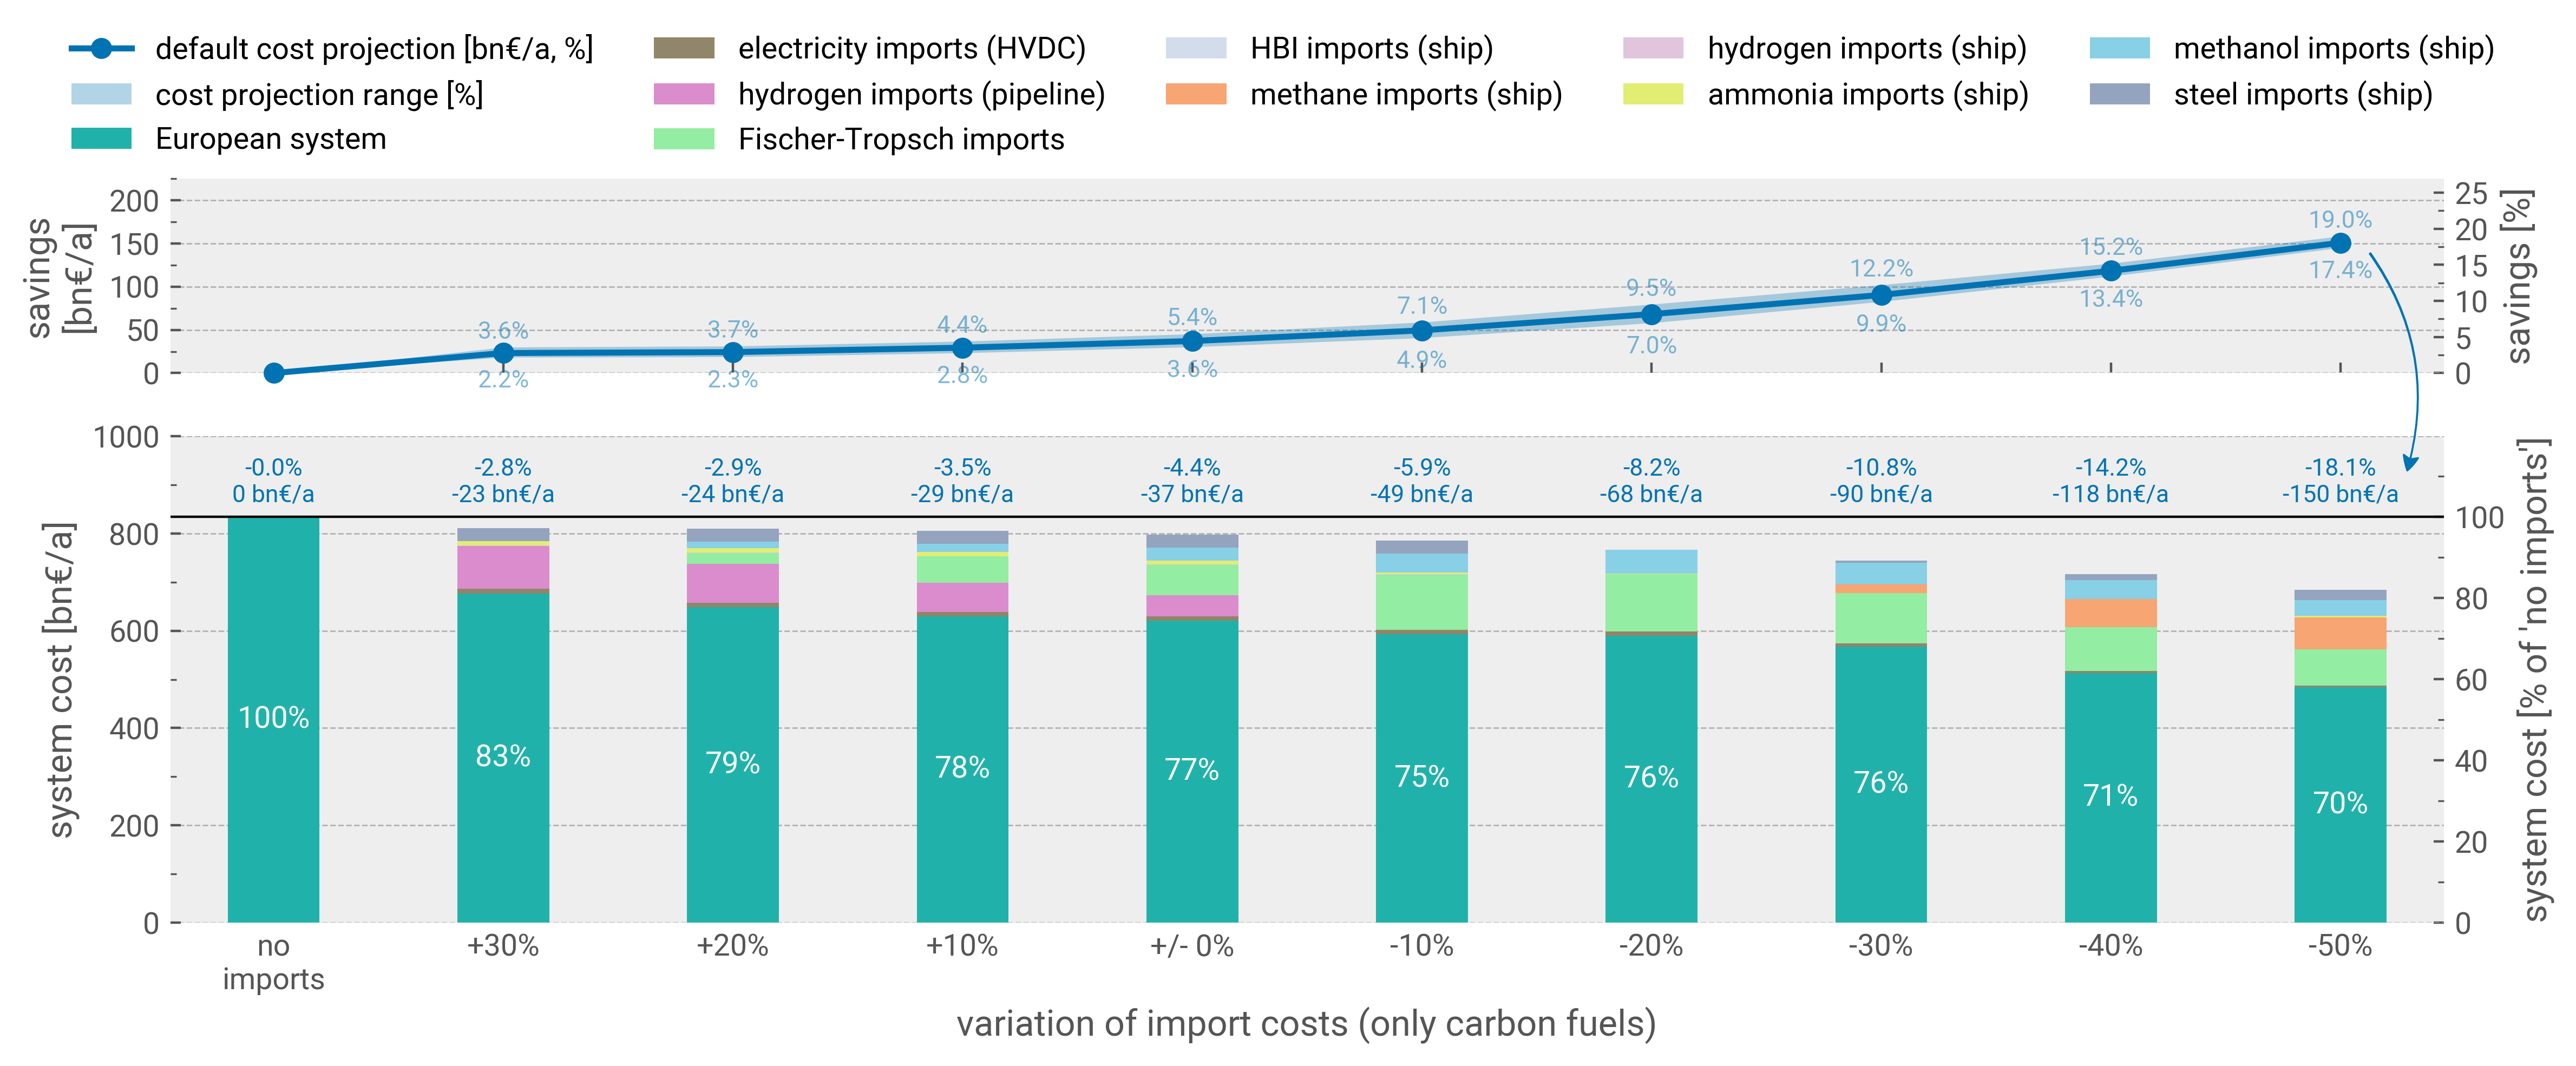

In [44]:
fig, (ax2, ax) = plt.subplots(
    2,
    1,
    figsize=(12, 4.3),
    gridspec_kw={"height_ratios": [1.2, 3]},
    sharex=True,
)

tech_colors["European system"] = "lightseagreen"
tech_colors["Import"] = "coral"

reference_cost = to_plot["no\nimports"].sum()

to_plot.T.plot.bar(ax=ax, stacked=True, width=0.4, color=tech_colors, legend=False)

ax.set_ylim([0, 1000])
ax.set_ylabel("system cost [bn€/a]")
ax.grid(axis="x")

ax.axhline(to_plot.sum().max(), linestyle="-", color="k", linewidth=0.8)

share = to_plot / to_plot.sum() * 100
reduction = ((-to_plot.sum() + to_plot.sum().max()) / to_plot.sum().max() * 100).round(
    1
)
abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

for i, scen in enumerate(to_plot.columns):
    ax.text(
        i,
        865,
        f"-{reduction[scen]}%\n{abs_reduction[scen]} bn€/a",
        ha="center",
        fontsize=8,
        color=base_colors[0],
        # bbox=dict(
        #     facecolor="white", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3"
        # ),
    )

ax.bar_label(
    ax.containers[0],
    labels=share.loc["European system"].astype(int).astype(str) + "%",
    label_type="center",
    color="white",
    fmt="%.0f",
)


ax.tick_params(rotation=0, labelsize=10)


def abs2rel(x):
    return x / reference_cost * 100


def rel2abs(x):
    return x * reference_cost / 100


secax = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax.set_ylabel("system cost [% of 'no imports']")

secax2 = ax2.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("savings [%]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

savings = to_plot.sum().max() - to_plot.sum()

savings.plot(ax=ax2, marker="o", color=base_colors[0], clip_on=False, label="default cost projection [bn€/a, %]")

savings_2030 = (reference_cost - to_plot_2030.sum() / to_plot_2030["no\nimports"].sum() * reference_cost).loc[savings.index]
savings_2050 = (reference_cost - to_plot_2050.sum() / to_plot_2050["no\nimports"].sum() * reference_cost).loc[savings.index]
ax2.fill_between(savings_2030.index, savings_2030, savings_2050, color=base_colors[0], alpha=0.3, linewidth=0, label="cost projection range [%]")
# savings_2030.plot(ax=ax2, color=base_colors[0], clip_on=False, linewidth=0.5, linestyle=":")
# savings_2050.plot(ax=ax2, color=base_colors[0], clip_on=False, linewidth=0.5, linestyle=":")

kwargs = dict(
    ha="center",
    fontsize=8,
    color=base_colors[0],
    alpha=0.5,
)

for i, scen in enumerate(savings_2030):
    if scen < 1:
        continue
    ax2.text(
        i,
        scen + 10,
        f"{scen/reference_cost*100:.1f}%",
        **kwargs
    )

for i, scen in enumerate(savings_2050):
    if scen < 5:
        continue
    ax2.text(
        i,
        scen - 35,
        f"{scen/reference_cost*100:.1f}%",
        **kwargs
    )

handles1, labels1 = ax.get_legend_handles_labels()
labels1 = [NICE_NAMES.get(i, i) for i in labels1]
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles2 + handles1
labels = labels2 + labels1
fig.legend(handles, labels, ncol=5, frameon=False, bbox_to_anchor=(0.975, 1.15))

fig.patches.extend([
    patches.FancyArrowPatch(
        (0.915, 0.89),  # Start point (x1, y1)
        (0.93, 0.645),  # End point (x2, y2)
        transform=fig.transFigure,  # Use figure coordinates
        connectionstyle="arc3,rad=-0.25",  # Straight arrow. Use non-zero rad for curved
        arrowstyle="fancy,head_length=5,head_width=5",
        color=base_colors[0]
    )
])

ax2.set_ylabel("savings\n[bn€/a]")
ax2.set_ylim(0, 225)
ax2.set_yticks(range(0, 226, 50))
ax2.grid(axis="x")
secax2.set_yticks([0, 5, 10, 15, 20, 25, 30])
secax2.set_yticks([2.5, 7.5, 12.5, 17.5, 22.5, 27.5], minor=True)
secax.set_yticks(range(10, 120, 20), minor=True)
ax.set_yticks(range(100, 1000, 200), minor=True)
ax2.set_yticks(range(0, 226, 25), minor=True)

ax.set_xlabel("variation of import costs (only carbon fuels)")

for ext in [".pdf", ".png"]:
    fig.savefig(OUTPUT + f"sensitivity-bars{suffix}" + ext, bbox_inches="tight")

In [45]:
suffix = "-all-wAC"
to_plot = df.loc[:, ~df.columns.get_level_values(0).isin(np.arange(500, 10001, 500))]

def prepare_to_plot(input_df):
    _df = input_df.copy()
    _df.columns = [
        "self-sufficient" if c[0] == 0.0 and c[1] == "none" else c[1]
        for c in _df.columns
    ]

    _df = _df.groupby(
        lambda x: x if "import" in x or "external" in x else "European system"
    ).sum()

    translate = {
        "self-sufficient": "no\nimports",
        "AC1.3+H21.3+CH41.3+NH31.3+FT1.3+MeOH1.3+HBI1.3+St1.3": "+30%",
        "AC1.2+H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+HBI1.2+St1.2": "+20%",
        "AC1.1+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+HBI1.1+St1.1": "+10%",
        "any": "+/- 0%",
        "AC0.9+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+HBI0.9+St0.9": "-10%",
        "AC0.8+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+HBI0.8+St0.8": "-20%",
        "AC0.7+H20.7+CH40.7+NH30.7+FT0.7+MeOH0.7+HBI0.7+St0.7": "-30%",
        "AC0.6+H20.6+CH40.6+NH30.6+FT0.6+MeOH0.6+HBI0.6+St0.6": "-40%",
        "AC0.5+H20.5+CH40.5+NH30.5+FT0.5+MeOH0.5+HBI0.5+St0.5": "-50%",
    }

    _df = _df.loc[:, translate.keys()].rename(columns=translate)

    _df = _df.loc[:, _df.sum().sort_values(ascending=False).index]

    _df = _df.groupby(
        lambda x: (
            "electricity imports (HVDC)"
            if x
            in [
                "external onwind",
                "external solar",
                "external battery",
                "import hvdc-to-elec",
            ]
            else x
        )
    ).sum()

    # make sure no imports is first
    first = "no\nimports"
    cols = [first] + [col for col in _df if col != first]
    return _df[cols]

to_plot = prepare_to_plot(to_plot)
to_plot_2030 = prepare_to_plot(df_2030)
to_plot_2050 = prepare_to_plot(df_2050)

abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

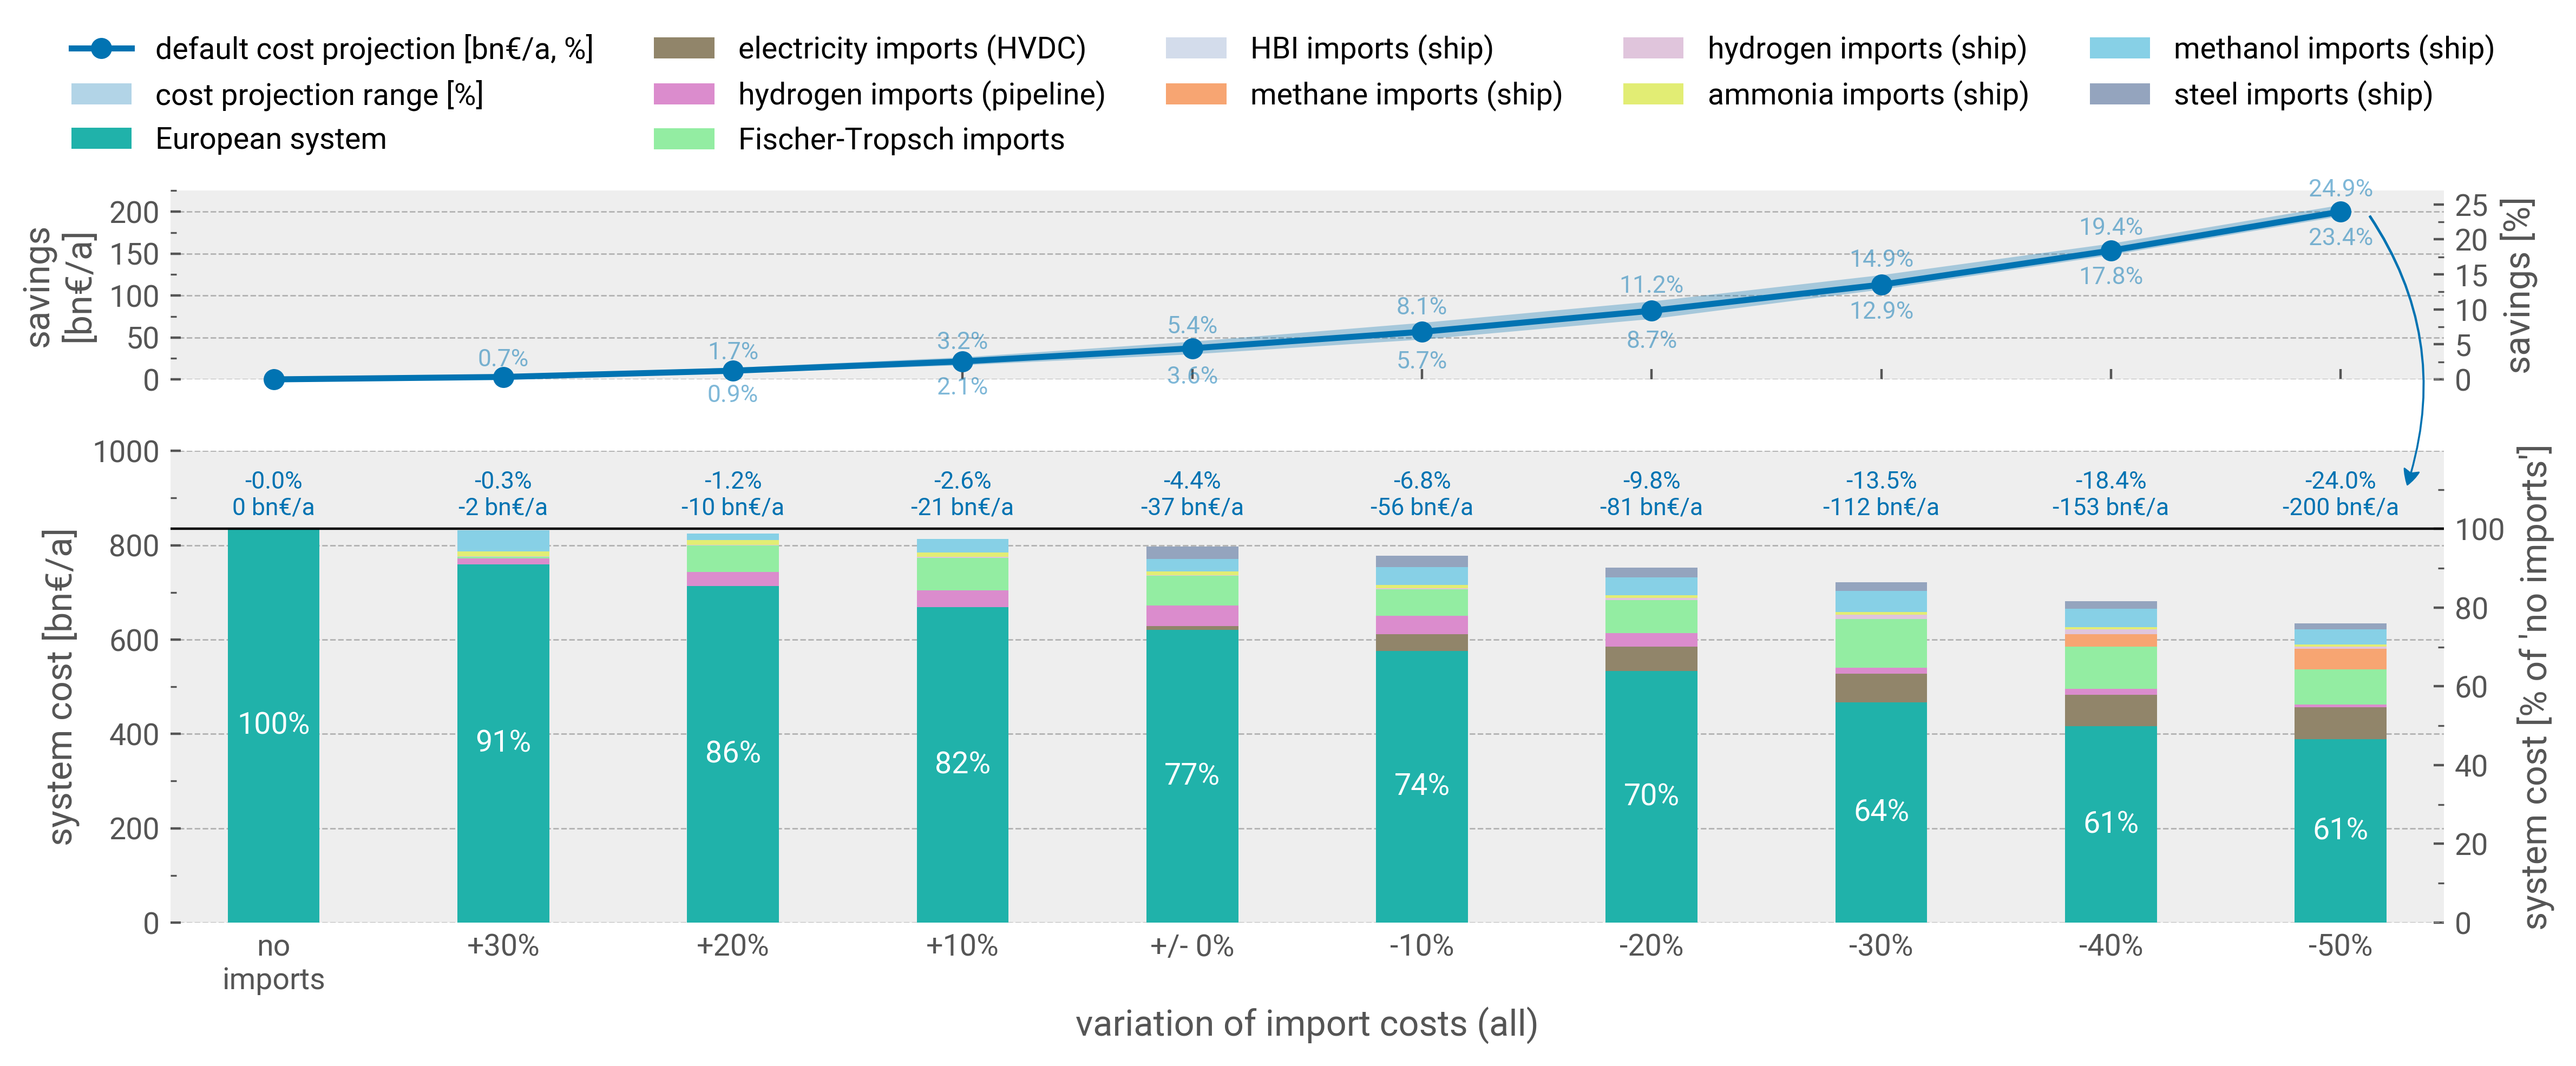

In [46]:
fig, (ax2, ax) = plt.subplots(
    2,
    1,
    figsize=(12, 4.3),
    gridspec_kw={"height_ratios": [1.2, 3]},
    sharex=True,
)

tech_colors["European system"] = "lightseagreen"
tech_colors["Import"] = "coral"

reference_cost = to_plot["no\nimports"].sum()

to_plot.T.plot.bar(ax=ax, stacked=True, width=0.4, color=tech_colors, legend=False)

ax.set_ylim([0, 1000])
ax.set_ylabel("system cost [bn€/a]")
ax.grid(axis="x")

ax.axhline(to_plot.sum().max(), linestyle="-", color="k", linewidth=0.8)

share = to_plot / to_plot.sum() * 100
reduction = ((-to_plot.sum() + to_plot.sum().max()) / to_plot.sum().max() * 100).round(
    1
)
abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

for i, scen in enumerate(to_plot.columns):
    ax.text(
        i,
        865,
        f"-{reduction[scen]}%\n{abs_reduction[scen]} bn€/a",
        ha="center",
        fontsize=8,
        color=base_colors[0],
        # bbox=dict(
        #     facecolor="white", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3"
        # ),
    )

ax.bar_label(
    ax.containers[0],
    labels=share.loc["European system"].astype(int).astype(str) + "%",
    label_type="center",
    color="white",
    fmt="%.0f",
)


ax.tick_params(rotation=0, labelsize=10)


def abs2rel(x):
    return x / reference_cost * 100


def rel2abs(x):
    return x * reference_cost / 100


secax = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax.set_ylabel("system cost [% of 'no imports']")

secax2 = ax2.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("savings [%]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

savings = to_plot.sum().max() - to_plot.sum()
savings.plot(ax=ax2, marker="o", color=base_colors[0], clip_on=False, label="default cost projection [bn€/a, %]")

savings_2030 = (reference_cost - to_plot_2030.sum() / to_plot_2030["no\nimports"].sum() * reference_cost).loc[savings.index]
savings_2050 = (reference_cost - to_plot_2050.sum() / to_plot_2050["no\nimports"].sum() * reference_cost).loc[savings.index]
ax2.fill_between(savings_2030.index, savings_2030, savings_2050, color=base_colors[0], alpha=0.3, linewidth=0, label="cost projection range [%]")
# savings_2030.plot(ax=ax2, color=base_colors[0], clip_on=False, linewidth=0.5, linestyle=":")
# savings_2050.plot(ax=ax2, color=base_colors[0], clip_on=False, linewidth=0.5, linestyle=":")

kwargs = dict(
    ha="center",
    fontsize=8,
    color=base_colors[0],
    alpha=0.5,
)

for i, scen in enumerate(savings_2030):
    if scen < 1:
        continue
    ax2.text(
        i,
        scen + 10,
        f"{scen/reference_cost*100:.1f}%",
        **kwargs
    )

for i, scen in enumerate(savings_2050):
    if scen < 5:
        continue
    ax2.text(
        i,
        scen - 35,
        f"{scen/reference_cost*100:.1f}%",
        **kwargs
    )

handles1, labels1 = ax.get_legend_handles_labels()
labels1 = [NICE_NAMES.get(i, i) for i in labels1]
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles2 + handles1
fig.legend(handles, labels, ncol=5, frameon=False, bbox_to_anchor=(0.975, 1.15))

fig.patches.extend([
    patches.FancyArrowPatch(
        (0.915, 0.93),  # Start point (x1, y1)
        (0.93, 0.63),  # End point (x2, y2)
        transform=fig.transFigure,  # Use figure coordinates
        connectionstyle="arc3,rad=-0.25",  # Straight arrow. Use non-zero rad for curved
        arrowstyle="fancy,head_length=5,head_width=5",
        color=base_colors[0]
    )
])

ax2.set_ylabel("savings\n[bn€/a]")
ax2.set_ylim(0, 225)
ax2.set_yticks(range(0, 226, 50))
ax2.grid(axis="x")
secax2.set_yticks([0, 5, 10, 15, 20, 25, 30])
secax2.set_yticks([2.5, 7.5, 12.5, 17.5, 22.5, 27.5], minor=True)
secax.set_yticks(range(10, 120, 20), minor=True)
ax.set_yticks(range(100, 1000, 200), minor=True)
ax2.set_yticks(range(0, 226, 25), minor=True)

ax.set_xlabel("variation of import costs (all)")

for ext in [".pdf", ".png"]:
    fig.savefig(OUTPUT + f"sensitivity-bars{suffix}" + ext, bbox_inches="tight")

In [47]:
colors = {
    "pipeline-h2": "#db8ccd",
    "shipping-lh2": "#e0c5dc",
    "shipping-lnh3": "#e2ed74",
    "shipping-lch4": "#f7a572",
    "shipping-ftfuel": "#93eda2",
    "shipping-meoh": "#87d0e6",
    "shipping-steel": "#94a4be",
    "shipping-hbi": "#d3dceb",
    "hvdc-to-elec": "#91856a",
}

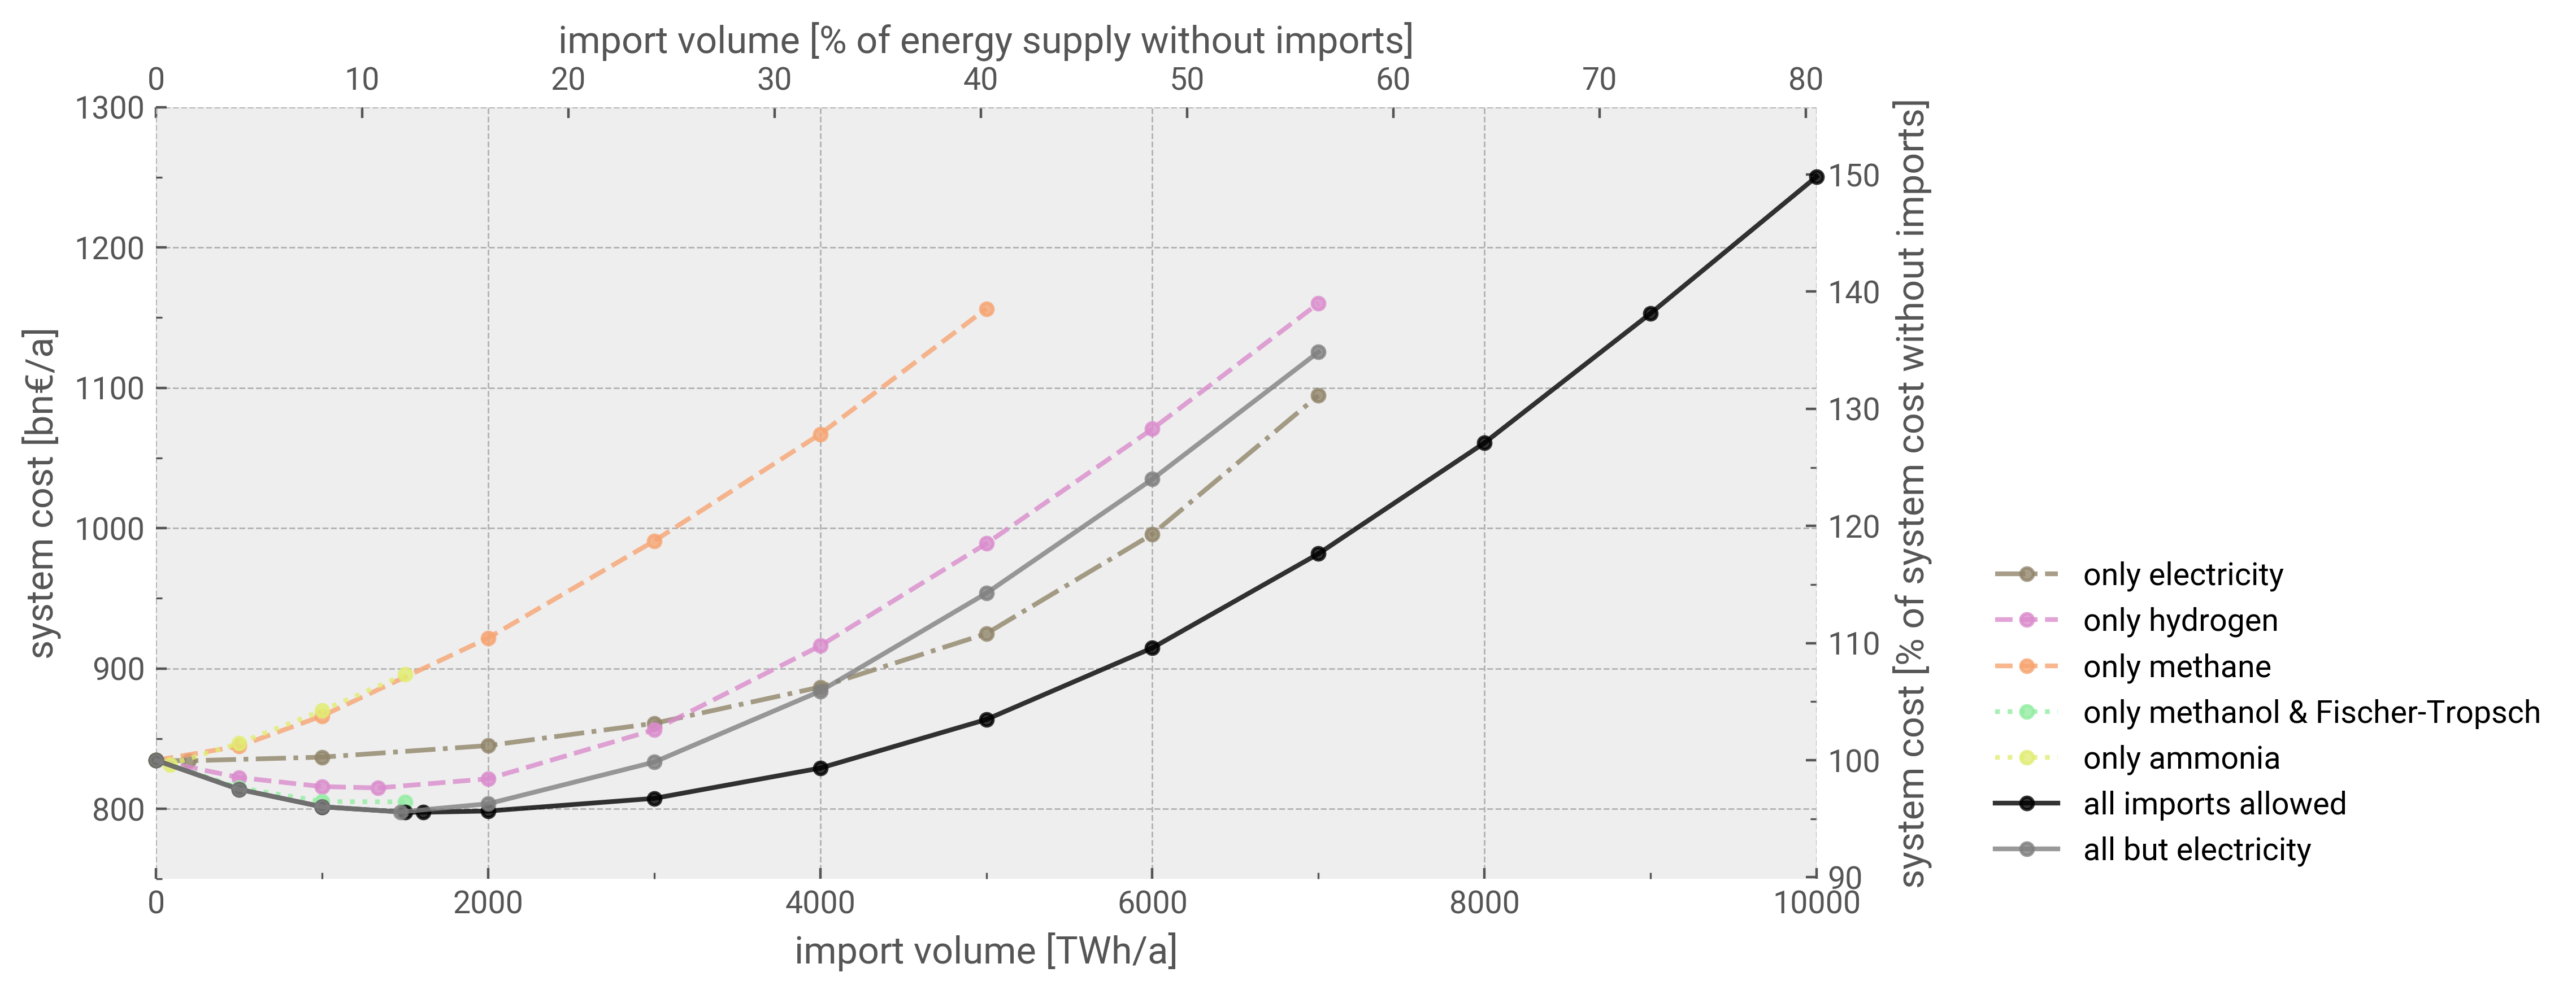

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(11.5, 4.5))

kwargs = dict(marker="o", markersize=4, linewidth=1.5, alpha=0.8, clip_on=False)

no_import = df.xs("none", level="carrier", axis=1).sum()[0]

to_plot = df.xs("AC", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color="#91856a", label="only electricity", linestyle="-."
)

to_plot = df.xs("H2", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color="#db8ccd", label="only hydrogen", linestyle="--"
)

to_plot = df.xs("CH4", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color="#f7a572", label="only methane", linestyle="--"
)

to_plot = df.xs("FT+MeOH", level="carrier", axis=1).sum()  # .drop(3000)
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color="#93eda2", label="only methanol & Fischer-Tropsch", linestyle=":"
)

to_plot = df.xs("NH3", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color="#e2ed74", label="only ammonia", linestyle=":"
)

to_plot = df.xs("any", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color="k", label="all imports allowed", linestyle="-"
)

to_plot = df.xs("H2+CH4+NH3+FT+MeOH+HBI+St", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color="grey", label="all but electricity", linestyle="-"
)


ax.set_ylim(750, 1300)
ax.set_ylabel("system cost [bn€/a]")
ax.grid(True)

plt.xlim(0, 10000)
ax.set_xlabel("import volume [TWh/a]")


def abs2rel(x):
    return x / 12418.5 * 100


def rel2abs(x):
    return x * 12418.5 / 100


secax = ax.secondary_xaxis("top", functions=(abs2rel, rel2abs))
secax.set_xlabel("import volume [% of energy supply without imports]")


def abs2rel(x):
    return x / to_plot[0] * 100


def rel2abs(x):
    return x * to_plot[0] / 100


secax2 = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("system cost [% of system cost without imports]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

ax.set_yticks(range(750, 1300, 50), minor=True)
ax.set_xticks(range(1000, 10000, 2000), minor=True)
secax.set_xticks(range(10, 100, 20), minor=True)
secax2.set_yticks(range(95, 130, 10), minor=True)

ax.legend(ncol=1, frameon=False, loc=(1.1, 0.0))

fig.savefig(OUTPUT + "sensitivity-lines.pdf", bbox_inches="tight")